# Inundation Area Detecton using Sentinel-1 & Deep Learning Models

## 0. Basic Settings

In [1]:
# Import libraries
import os
import sys
import glob
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import rasterio
from rasterio.plot import show
from tqdm import tqdm

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Optuna
import optuna

# MEALPY & MAFESE
from mealpy.evolutionary_based import GA
from mealpy.swarm_based import PSO
from mealpy.swarm_based import ABC
from mealpy.physics_based import SA

from mafese import MhaSelector
from mafese import MultiMhaSelector

# Set base directory
base_FP = '/home/work/seongjun'

# Add python_modules to sys.path
sys.path.append(os.path.join(base_FP, 'github'))

# Slack for notification
import slack_code_notifier.slack_notifier as Slack # type: ignore
env_path = os.path.join(base_FP, '.env')
load_dotenv(dotenv_path=env_path)
webhook_url_from_env = os.getenv('SLACK_WEBHOOK_URL')
notipy = Slack.Notifier(webhook_url_from_env)

In [41]:
# Fix seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define paths
IRAN_SAR_POL_PATH = os.path.join(base_FP, 'flood_detection/Iran/bands_Sentinel_1B_SLC_Iran_20190408.tif')
IRAN_SAR_DECOMP_PATH = os.path.join(base_FP, 'flood_detection/Iran/decomp_Sentinel_1B_SLC_Iran_20190408.tif')
IRAN_SAR_TEXTURE_PATH = os.path.join(base_FP, 'flood_detection/Iran/texture_Sentinel_1B_SLC_Iran_20190408.tif')
IRAN_LABEL_PATH = os.path.join(base_FP, 'flood_detection/Iran/digitized_labeled_data.tif') # Digitized data
# IRAN_LABEL_PATH = os.path.join(base_FP, 'flood_detection/Iran/labeled_data.tif') # Copernicus EMS

# List of SAR paths
IRAN_SAR_PATHS = [IRAN_SAR_POL_PATH, IRAN_SAR_DECOMP_PATH, IRAN_SAR_TEXTURE_PATH]

NK_SAR_POL_PATH = os.path.join(base_FP, 'flood_detection/North_Korea/bands_Sentinel_1_SLC_North_Korea_20240803.tif')
NK_SAR_DECOMP_PATH = os.path.join(base_FP, 'flood_detection/North_Korea/decomp_Sentinel_1_SLC_North_Korea_20240803.tif')
NK_SAR_TEXTURE_PATH = os.path.join(base_FP, 'flood_detection/North_Korea/texture_Sentinel_1_SLC_North_Korea_20240803.tif')
NK_LABEL_PATH = os.path.join(base_FP, 'flood_detection/North_Korea/digitized_labeled_data.tif') # Digitized data

NK_SAR_PATHS = [NK_SAR_POL_PATH, NK_SAR_DECOMP_PATH, NK_SAR_TEXTURE_PATH]

## 1. Define Functions

### 1) Load Data

In [3]:
# =====================================================================================#
# Load Data
# =====================================================================================#
def load_data(sar_paths, label_path):
    """
    Loads all SAR and label raster files from disk and returns them as numpy arrays.
    """
    # Load and combine all SAR data
    sar_data_list = []
    meta_data = None
    for i, path in enumerate(sar_paths):
        with rasterio.open(path) as src:
            if i == 0:
                meta_data = src.meta.copy() # Save metadata for later use
            sar_data_list.append(src.read())
    combined_sar_data = np.vstack(sar_data_list)

    # Load and process the label data
    with rasterio.open(label_path) as lbl_src:
        labeled_data = lbl_src.read(1)
        nodata_value = lbl_src.nodata
        if nodata_value is not None:
            labeled_data[labeled_data == nodata_value] = 0
        labeled_data = labeled_data.astype(np.uint8)

    print(f"SAR data shape: {combined_sar_data.shape}")
    print(f"Labeled data shape: {labeled_data.shape}")
    return combined_sar_data, labeled_data, meta_data

### 2) Crate Patches

In [4]:
# =====================================================================================#
# Create Patches
# =====================================================================================#
def create_patches(sar_data, labeled_data, patch_size):
    """
    Normalizes the pre-loaded SAR image and creates patches.
    """
    # Normalize the combined SAR data
    c, h, w = sar_data.shape
    normalized_sar_data = np.copy(sar_data) # Create a copy to avoid modifying the original
    for i in range(c):
        channel_data = normalized_sar_data[i].flatten().reshape(-1, 1)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(channel_data)
        normalized_sar_data[i] = scaled_data.reshape(h, w)

    # Create patches
    image_patches = []
    label_patches = []
    for y in tqdm(range(0, h - patch_size + 1, patch_size), desc="Creating Patches"):
        for x in range(0, w - patch_size + 1, patch_size):
            image_patch = normalized_sar_data[:, y:y+patch_size, x:x+patch_size]
            label_patch = labeled_data[y:y+patch_size, x:x+patch_size]

            if np.sum(label_patch) > 100:
                image_patches.append(image_patch)
                label_patches.append(label_patch)

    print(f"Patch creation complete. Number of patches: {len(image_patches)}")
    # Return normalized data for inference as well
    return np.array(image_patches), np.array(label_patches), normalized_sar_data

### 3) Prepare Datasets


In [5]:
class FloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.from_numpy(images).float()
        self.labels = torch.from_numpy(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            pass # Augmentation logic can be added here
        return image, label

### 4) Model Training

In [6]:
def train_model(model_name, model_class, train_loader, val_loader,
                total_channels, num_epochs, lr, patience, save_path):
    """
    Trains and evaluates a single deep learning model.

    Args:
        model_name (str): The name of the model for saving.
        model_class: The model class to instantiate.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        total_channels (int): Number of input channels for the model.
        num_epochs (int): The total number of epochs.
        lr (float): Learning rate.
        patience (int): Patience for early stopping.

    Returns:
        tuple: A tuple containing (best_iou, best_f1_score, history_log).
    """
    print(f"{'='*30} 🖥️ Training {model_name} model {'='*30}")

    # --- Initialize variables for this run ---
    best_iou = 0.0
    best_f1_score = 0.0
    early_stopping_counter = 0
    best_val_loss = float('inf')
    history = {
        'train_loss': [], 'val_loss': [], 'accuracy': [], 'iou': [],
        'precision': [], 'recall': [], 'f1_score': []
    }

    # --- Initialize model, criterion, optimizer, scheduler ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_class(in_channels=total_channels, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # --- Training Loop ---
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- Validation Loop ---
        model.eval()
        val_loss = 0.0
        total_tp, total_tn, total_fp, total_fn = 0, 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                total_tp += torch.logical_and(preds == 1, labels == 1).sum().item()
                total_tn += torch.logical_and(preds == 0, labels == 0).sum().item()
                total_fp += torch.logical_and(preds == 1, labels == 0).sum().item()
                total_fn += torch.logical_and(preds == 0, labels == 1).sum().item()

        # --- Calculate metrics and update history ---
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        epsilon = 1e-6
        accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + epsilon)
        iou = total_tp / (total_tp + total_fp + total_fn + epsilon)
        precision = total_tp / (total_tp + total_fp + epsilon)
        recall = total_tp / (total_tp + total_fn + epsilon)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        for metric, value in zip(history.keys(), [avg_train_loss, avg_val_loss, accuracy, iou, precision, recall, f1]):
            history[metric].append(value)

        # --- Save model and check for early stopping ---
        if iou > best_iou:
            best_iou = iou
            best_f1_score = f1
            torch.save(model.state_dict(), f'{save_path}/best_{model_name}_model.pth')
            print(f"Epoch {epoch+1}: 🎉 New best IoU: {best_iou:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}\n")
            break

    print(f"--- Finished training for {model_name} ---")
    return best_iou, best_f1_score, history

### 5) Inference

In [84]:
def inference(model, normalized_data, patch_size):
    """
    Performs sliding window inference on a full-size image.

    Args:
        model: The trained PyTorch model in eval mode.
        normalized_data (np.array): The pre-processed, normalized input data.
        patch_size (int): The size of the patches (e.g., 256).

    Returns:
        np.array: The final 2D prediction map.
    """
    device = next(model.parameters()).device
    h, w = normalized_data.shape[1:]
    prediction_map = np.zeros((h, w), dtype=np.uint8)

    with torch.no_grad():
        for y in tqdm(range(0, h, patch_size), desc="Processing Rows"):
            for x in range(0, w, patch_size):
                y_end = min(y + patch_size, h)
                x_end = min(x + patch_size, w)
                patch = normalized_data[:, y:y_end, x:x_end]

                patch_h, patch_w = patch.shape[1], patch.shape[2]

                if patch_h != patch_size or patch_w != patch_size:
                    pad_h = patch_size - patch_h
                    pad_w = patch_size - patch_w
                    patch = np.pad(patch, ((0, 0), (0, pad_h), (0, pad_w)), mode='constant')

                patch_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)
                output = model(patch_tensor)
                pred_patch_full = torch.argmax(output, dim=1).squeeze().cpu().numpy()
                pred_patch = pred_patch_full[:patch_h, :patch_w]

                prediction_map[y:y_end, x:x_end] = pred_patch
    return prediction_map

### 6) Plot Flood Prediction Map

In [111]:
def plot_prediction_map(prediction_map, meta_data, model_name, best_iou, best_f1_score, color_map):
    """
    Plots the model's prediction map.
    """
    # Create a single figure and axis object, not a subplot grid.
    # Adjusted figsize for a single plot.
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Define a simple colormap for the binary map (0: black, 1: lightskyblue)
    colors = ['black', color_map]
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Display the model's prediction map on the single axis 'ax'
    show(prediction_map, ax=ax, transform=meta_data['transform'], cmap=cmap, norm=norm)

    # Set plot titles and labels for the single axis 'ax'
    ax.set_title(f'{model_name} Prediction\n(IoU: {best_iou:.4f} / F1 Score: {best_f1_score:.4f})', fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=15, labelpad=10)
    ax.set_ylabel('Latitude', fontsize=15, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

## 2. Define Model Architecture

### 1) Gated-SCNN

In [9]:
# 반복되는 Convolution Block을 작은 모듈로 정의
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# 테이블 구조를 기반으로 한 Gated-SCNN 모델
class GatedSCNN(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(GatedSCNN, self).__init__()

        # 1. Main Branch (다운샘플링 없음)
        self.main_branch = nn.Sequential(
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )

        # 2. Shape Branch (다운샘플링 없음)
        self.shape_branch = nn.Sequential(
            ConvBlock(in_channels, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128)
        )

        # 3. Gating Mechanism
        self.gating_main_conv = nn.Conv2d(256, 256, kernel_size=1)
        self.gating_shape_conv = nn.Conv2d(128, 256, kernel_size=1)

        # 4. Decoder
        self.decoder = nn.Sequential(
            ConvBlock(256, 128),
            # 테이블의 마지막 1x1 Conv를 num_classes에 맞게 수정
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

        # 참고: 테이블의 최종 Sigmoid 활성화 함수는 nn.CrossEntropyLoss를
        # 사용하기 위해 생략합니다. (CrossEntropyLoss에 Softmax가 포함되어 있음)

    def forward(self, x):
        # Get the height and width of the input
        h, w = x.size()[2:]

        # Pass the input to each branch
        main_features = self.main_branch(x)   # (Batch, 256, 256, 256)
        shape_features = self.shape_branch(x) # (Batch, 128, 256, 256)

        # Gating operation
        gated_main = self.gating_main_conv(main_features)
        gated_shape = self.gating_shape_conv(shape_features)

        gate = torch.sigmoid(gated_shape)
        gated_features = gated_main * gate

        # Generate the final output through the decoder
        out = self.decoder(gated_features)

        # Resize the output to the original size
        out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)

        return out

### 2) U-Net ++

In [10]:
# U-Net ++
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Model architecture
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(UNetPlusPlus, self).__init__()

        num_filters = [32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Encoder path (Pyramid's left edge)
        self.conv0_0 = ConvBlock(in_channels, num_filters[0])
        self.conv1_0 = ConvBlock(num_filters[0], num_filters[1])
        self.conv2_0 = ConvBlock(num_filters[1], num_filters[2])
        self.conv3_0 = ConvBlock(num_filters[2], num_filters[3])
        self.conv4_0 = ConvBlock(num_filters[3], num_filters[4])

        # Nested skip pathways
        self.conv0_1 = ConvBlock(num_filters[0] + num_filters[1], num_filters[0])
        self.conv1_1 = ConvBlock(num_filters[1] + num_filters[2], num_filters[1])
        self.conv2_1 = ConvBlock(num_filters[2] + num_filters[3], num_filters[2])
        self.conv3_1 = ConvBlock(num_filters[3] + num_filters[4], num_filters[3])

        self.conv0_2 = ConvBlock(num_filters[0] * 2 + num_filters[1], num_filters[0])
        self.conv1_2 = ConvBlock(num_filters[1] * 2 + num_filters[2], num_filters[1])
        self.conv2_2 = ConvBlock(num_filters[2] * 2 + num_filters[3], num_filters[2])

        self.conv0_3 = ConvBlock(num_filters[0] * 3 + num_filters[1], num_filters[0])
        self.conv1_3 = ConvBlock(num_filters[1] * 3 + num_filters[2], num_filters[1])

        self.conv0_4 = ConvBlock(num_filters[0] * 4 + num_filters[1], num_filters[0])

        # Final output layer
        # Compatible with CrossEntropyLoss
        self.final_conv = nn.Conv2d(num_filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Get the height and width of the input
        h, w = x.size()[2:]

        # Encoder path
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        # Final output
        output = self.final_conv(x0_4)

        # Resize the output to the original size
        output = F.interpolate(output, size=(h, w), mode='bilinear', align_corners=True)

        return output

### 3) CPNet

In [11]:
# CPNet
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

# Implement Context Prior Module
class ContextPriorModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContextPriorModule, self).__init__()
        self.conv_in = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # 2 x [Conv2d]
        attention = self.conv_in(x)
        # Sigmoid(attention reweighting)
        attention = torch.sigmoid(attention)
        # Element-wise multiplication
        out = x * attention
        out = self.conv_out(out)
        return out

# Model architecture
class CPNet(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(CPNet, self).__init__()

        # --- Encoder ---
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Bottleneck ---
        self.bottleneck = ConvBlock(512, 512)
        self.context_prior = ContextPriorModule(512, 512)

        # --- Decoder ---
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(256 + 512, 256) # Concatenate(Up4 & Enc4)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(128 + 256, 128) # Concatenate(Up3 & Enc3)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(64 + 128, 64) # Concatenate(Up2 & Enc2)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(32 + 64, 32) # Concatenate(Up1 & Enc1)

        # --- Output Layer ---
        # Output layer compatible with CrossEntropyLoss
        self.output_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        # Get the height and width of the input
        h, w = x.size()[2:]

        # Encoder path
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck path
        b = self.bottleneck(p4)
        b = self.context_prior(b)

        # Decoder path
        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final output
        out = self.output_conv(d1)

        # Resize the output to the original size
        out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)

        return out

### 4) VGG16-UNet

In [12]:
# VGG16-UNet
class VGG16UNet(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(VGG16UNet, self).__init__()

        # --- Pre-trained VGG16 Encoder ---
        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Modify the first Conv layer of VGG16 to match the input channel number
        # (Average the weights of the original 3 channels to initialize the new channels)
        original_conv1 = vgg16.features[0]
        new_conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            new_conv1.weight.data.normal_(0, 0.01) # Initialize the new weights
            avg_weights = original_conv1.weight.data.mean(dim=1, keepdim=True)
            new_conv1.weight.data[:, :1, :, :] = avg_weights # Example: Use the average weights for the first channel

        # Use each block of VGG16 as an encoder
        self.encoder1 = nn.Sequential(new_conv1, *vgg16.features[1:4]) # 64 channels
        self.encoder2 = nn.Sequential(*vgg16.features[4:9])            # 128 channels
        self.encoder3 = nn.Sequential(*vgg16.features[9:16])           # 256 channels
        self.encoder4 = nn.Sequential(*vgg16.features[16:23])          # 512 channels
        self.encoder5 = nn.Sequential(*vgg16.features[23:30])          # 512 channels

        # --- Decoder ---
        # Implement the UpSampling2D + Conv2D x 2 structure of the table
        self.up_conv5 = self._make_decoder_block(512, 512)
        self.dec_block4 = self._make_decoder_block(1024, 512)

        self.up_conv4 = self._make_decoder_block(512, 256)
        self.dec_block3 = self._make_decoder_block(512, 256)

        self.up_conv3 = self._make_decoder_block(256, 128)
        self.dec_block2 = self._make_decoder_block(256, 128)

        self.up_conv2 = self._make_decoder_block(128, 64)
        self.dec_block1 = self._make_decoder_block(128, 64)

        # --- Output Layer ---
        self.output_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_decoder_block(self, in_channels, out_channels):
        # UpSampling2D(x2) + 2 x Conv(3x3)
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Get the height and width of the input
        h, w = x.size()[2:]

        # --- Encoder Path ---
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        # --- Decoder Path ---
        dec5 = self.up_conv5(enc5)
        # Match the size of dec5 to enc4
        dec5 = F.interpolate(dec5, size=enc4.shape[2:], mode='bilinear', align_corners=True)
        dec4 = torch.cat([dec5, enc4], dim=1)
        dec4 = self.dec_block4(dec4)

        dec4_up = self.up_conv4(dec4)
        # Match the size of dec4_up to enc3
        dec4_up = F.interpolate(dec4_up, size=enc3.shape[2:], mode='bilinear', align_corners=True)
        dec3 = torch.cat([dec4_up, enc3], dim=1)
        dec3 = self.dec_block3(dec3)

        dec3_up = self.up_conv3(dec3)
        # Match the size of dec3_up to enc2
        dec3_up = F.interpolate(dec3_up, size=enc2.shape[2:], mode='bilinear', align_corners=True)
        dec2 = torch.cat([dec3_up, enc2], dim=1)
        dec2 = self.dec_block2(dec2)

        dec2_up = self.up_conv2(dec2)
        # Match the size of dec2_up to enc1
        dec2_up = F.interpolate(dec2_up, size=enc1.shape[2:], mode='bilinear', align_corners=True)
        dec1 = torch.cat([dec2_up, enc1], dim=1)
        dec1 = self.dec_block1(dec1)

        # --- Final Output ---
        out = self.output_conv(dec1)

        # Resize the output to the original size
        out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)

        return out

### 5) DRN

In [13]:
# DRN
# BasicBlock
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(BasicBlock, self).__init__()
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Downsample path (if needed)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity # Residual Addition
        out = self.relu(out)

        return out

# Model architecture
class DRN(nn.Module):
    def __init__(self, in_channels, num_classes=2):
        super(DRN, self).__init__()

        # Initial block
        self.conv1_block = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Residual layers with dilation
        self.layer1 = self._make_layer(BasicBlock, 64, 64, blocks=2, stride=1, dilation=1)
        self.layer2 = self._make_layer(BasicBlock, 64, 128, blocks=2, stride=1, dilation=2)
        self.layer3 = self._make_layer(BasicBlock, 128, 256, blocks=2, stride=1, dilation=4)
        self.layer4 = self._make_layer(BasicBlock, 256, 512, blocks=2, stride=1, dilation=8)

        # Segmentation head
        self.segmentation_head = nn.Conv2d(512, num_classes, kernel_size=1)

        # Note: Upsampling and Sigmoid are omitted for nn.CrossEntropyLoss usage

    def _make_layer(self, block, in_channels, out_channels, blocks, stride, dilation):
        layers = []
        # The first block can change the channel number or size
        layers.append(block(in_channels, out_channels, stride, dilation))
        # The remaining blocks maintain the size and channel number
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, stride=1, dilation=dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        h, w = x.size()[2:]

        x = self.conv1_block(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.segmentation_head(x)

        # Final output is restored to the original image size (if needed)
        # This model maintains the resolution, so it may not be needed, but it is added for reference
        out = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        return out

## 3. Datasets

### 3.1. Data Inspection (Optional)

In [17]:
# Dictionary of files to inspect
files_to_inspect = {
    "SAR Polarimetric": IRAN_SAR_POL_PATH,
    "SAR Decomposition": IRAN_SAR_DECOMP_PATH,
    "SAR Texture": IRAN_SAR_TEXTURE_PATH,
    "Labeled Data": IRAN_LABEL_PATH
}

# Loop through the dictionary and inspect each file
for name, path in files_to_inspect.items():
    print(f"=============== Inspecting {name} ================")
    try:
        with rasterio.open(path) as src:
            # --- 1) Basic metadata ---
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            print(f"Resolution: {src.res}")

            # --- 2) Numpy array data ---
            img_array = src.read()
            print(f"Shape: {img_array.shape}")
            print(f"Data type: {img_array.dtype}")

    except Exception as e:
        print(f"🚨 Error reading file '{path}': {e}\n")

=============== Inspecting SAR Polarimetric ================
CRS: EPSG:4326
Bounds: BoundingBox(left=48.29994692663589, bottom=30.900024740011144, right=48.899931704899316, top=32.0000118054155)
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Shape: (4, 12245, 6679)
Data type: float32
=============== Inspecting SAR Decomposition ================
CRS: EPSG:4326
Bounds: BoundingBox(left=48.29994692663589, bottom=30.900024740011144, right=48.899931704899316, top=32.0000118054155)
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Shape: (3, 12245, 6679)
Data type: float32
=============== Inspecting SAR Texture ================
CRS: EPSG:4326
Bounds: BoundingBox(left=48.29994692663589, bottom=30.900024740011144, right=48.899931704899316, top=32.0000118054155)
Resolution: (8.983152841195215e-05, 8.983152841195215e-05)
Shape: (20, 12245, 6679)
Data type: float32
=============== Inspecting Labeled Data ================
CRS: EPSG:4326
Bounds: BoundingBox(left=48.299946927, b

### 3.2. Define Feature Names for Input Data

In [14]:
# SAR Polarimetric data
pol_features = ['vv', 'vh', 'diff_vv_vh', 'mul_vv_vh']

# Decomposited SAR data
decomp_features = ['decomp_entropy', 'decomp_anisotropy', 'decomp_alpha']

# GLCM texture features
texture_features = [
    'vv_contrast', 'vv_dissimilarity', 'vv_homogeneity', 'vv_asm', 'vv_energy',
    'vv_max', 'vv_entropy', 'vv_GLCMmean', 'vv_GLCMvariance', 'vv_GLCMcorrelation',
    'vh_contrast', 'vh_dissimilarity', 'vh_homogeneity', 'vh_asm', 'vh_energy',
    'vh_max', 'vh_entropy', 'vh_GLCMmean', 'vh_GLCMvariance', 'vh_GLCMcorrelation'
]

all_feature_names = pol_features + decomp_features + texture_features
num_channels = len(all_feature_names)

print(f"Total number of defined features: {len(all_feature_names)}")

Total number of defined features: 27


### 3.3. Data Load

In [62]:
# Load Data
combined_sar_data, labeled_data, iran_meta_data= load_data(IRAN_SAR_PATHS, IRAN_LABEL_PATH)
labeled_origin_data = labeled_data.copy()

SAR data shape: (27, 12245, 6679)
Labeled data shape: (12245, 6679)


In [71]:
# Define the patch size
PATCH_SIZE = 256

# Create patches
image_patches, label_patches, normalized_sars_data = create_patches(combined_sar_data, labeled_data, PATCH_SIZE) # normalized data for inference

Creating Patches: 100%|██████████| 47/47 [00:00<00:00, 688.09it/s]


Patch creation complete. Number of patches: 961


## 4. Metaheuristic-based Feature Selection

### 4.1. Data Split for Feature Selection

In [17]:
# Data for Feature Selection
N_SAMPLES_PER_CLASS = 250  # Number of samples per class
h, w = labeled_data.shape

fs_patches = []  # List of SAR patches for feature selection
fs_labels = []   # List of labels for feature selection (0 or 1)

# Sampling "Flood" patches
flood_patches_found = 0
while flood_patches_found < N_SAMPLES_PER_CLASS:
    # Randomly select a position in the image
    y = np.random.randint(0, h - PATCH_SIZE)
    x = np.random.randint(0, w - PATCH_SIZE)

    label_patch = labeled_data[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

    # Check if the patch is a "Flood" patch
    if label_patch.sum() > 100:
        sar_patch = combined_sar_data[:, y:y+PATCH_SIZE, x:x+PATCH_SIZE]
        fs_patches.append(sar_patch)
        fs_labels.append(1)
        flood_patches_found += 1

# Sampling "Non-Flood" patches
non_flood_patches_found = 0
while non_flood_patches_found < N_SAMPLES_PER_CLASS:
    y = np.random.randint(0, h - PATCH_SIZE)
    x = np.random.randint(0, w - PATCH_SIZE)

    label_patch = labeled_data[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

    # Check if the patch is a "Non-Flood" patch (all pixels are 0)
    if label_patch.sum() == 0:
        sar_patch = combined_sar_data[:, y:y+PATCH_SIZE, x:x+PATCH_SIZE]
        fs_patches.append(sar_patch)
        fs_labels.append(0)
        non_flood_patches_found += 1

# Create final data for feature selection
X_stats = np.array([patch.mean(axis=(1, 2)) for patch in fs_patches])
y_labels = np.array(fs_labels)

print(f"Shape of data for feature selection: X={X_stats.shape}, y={y_labels.shape}")
print(f"Class distribution: {dict(zip(*np.unique(y_labels, return_counts=True)))}")

Shape of data for feature selection: X=(500, 27), y=(500,)
Class distribution: {0: 250, 1: 250}


### 4.2.Hyperprameter Optimization 

In [ ]:
# Metaheuristic optimizer configurations
optimizers_config = {
    "ABC": {
        "class": ABC.OriginalABC,
        "params": {
            "pop_size": {"type": "suggest_int", "args": {"low": 30, "high": 50, "step": 10}},
            "n_limits": {"type": "suggest_int", "args": {"low": 20, "high": 100, "step": 10}},
        }
    },
    "GA": {
        "class": GA.BaseGA,
        "params": {
            "pop_size": {"type": "suggest_int", "args": {"low": 20, "high": 50, "step": 10}},
            "pc": {"type": "suggest_categorical", "args": {"choices": np.arange(0.7, 0.95, 0.05).round(2).tolist()}},
            "pm": {"type": "suggest_categorical", "args": {"choices": np.arange(0.01, 0.2, 0.01).round(2).tolist()}}
        }
    },
    "PSO": {
        "class": PSO.OriginalPSO,
        "params": {
            "pop_size": {"type": "suggest_int", "args": {"low": 20, "high": 50, "step": 10}},
            # These are also discrete steps, so categorical is better
            "w": {"type": "suggest_categorical", "args": {"choices": np.arange(0.4, 1.0, 0.1).round(1).tolist()}},
            "c1": {"type": "suggest_categorical", "args": {"choices": np.arange(1.0, 3.0, 0.1).round(1).tolist()}},
            "c2": {"type": "suggest_categorical", "args": {"choices": np.arange(1.0, 3.0, 0.1).round(1).tolist()}}
        }
    },
    "SwarmSA": {
        "class": SA.SwarmSA,
        "params": {
            "pop_size": {"type": "suggest_int", "args": {"low": 30, "high": 50, "step": 10}},
            "max_sub_iter": {"type": "suggest_categorical", "args": {"choices": [5, 10, 15]}},
            "move_count": {"type": "suggest_categorical", "args": {"choices": [5, 10, 15]}},
            "mutation_rate": {"type": "suggest_categorical", "args": {"choices": np.arange(0.01, 0.20, 0.01).round(2).tolist()}},
            "mutation_step_size": {"type": "suggest_categorical", "args": {"choices": [0.05, 0.1, 0.15]}},
            "mutation_step_size_damp": {"type": "suggest_categorical", "args": {"choices": np.arange(0.8, 0.99, 0.01).round(2).tolist()}}
        }
    }
}

In [ ]:
# Hyperparameter tuning using Optuna
def objective(trial, optimizer_name):
    """
    Optuna's objective function to tune hyperparameters for a given optimizer.
    """
    config = optimizers_config[optimizer_name]
    hyperparams = {}

    for param_name, settings in config["params"].items():
        # Get the corresponding 'suggest' method from the trial object
        suggest_method = getattr(trial, settings["type"])

        # Unpack the 'args' dictionary as keyword arguments using **
        value = suggest_method(param_name, **settings["args"])

        # Round the value based on the step size
        if "step" in settings["args"] and settings["args"]["step"] == 0.01:
            value = round(value, 2)
        elif "step" in settings["args"] and settings["args"]["step"] == 0.05:
            value = round(value, 2)
        elif "step" in settings["args"] and settings["args"]["step"] == 0.1:
            value = round(value, 1)

        hyperparams[param_name] = value

    # Create an instance of the optimizer with the suggested hyperparameters
    optimizer_instance = config["class"](epoch=5, **hyperparams)

    # Create and run the MhaSelector
    selector = MhaSelector(problem="classification", obj_name="F1S",
                           estimator="xgb", optimizer=optimizer_instance, verbose=False)
    selector.fit(X_stats, y_labels)

    # Return the best fitness score from this trial
    best_fitness = selector.optimizer.g_best.target.fitness
    return best_fitness

# --- Main execution loop for all optimizers ---

results = []
n_trials = 50

for name in optimizers_config.keys():
    print(f"===== Starting Hyperparameter Tuning for {name} =====")

    study = optuna.create_study(direction="maximize")

    # The lambda function passes the optimizer's name to the objective
    study.optimize(lambda trial: objective(trial, name), n_trials=n_trials, n_jobs=-1)

    best_trial = study.best_trial

    result_entry = {
        'Algorithm': name,
        'Best F1-Score': best_trial.value,
        **best_trial.params
    }
    results.append(result_entry)

    print(f"\n----- Results for {name} -----")
    print(f"  Best F1-Score: {best_trial.value:.4f}")
    print("  Best Parameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    print("--------------------------\n")

# Convert the list of results into a pandas DataFrame
results_df = pd.DataFrame(results)

print("\n===== Final Optimization Summary =====")
print(results_df.to_string())

### 4.3. Feature Selection

In [19]:
# Define optimizers and their parameters
list_optimizers = ("OriginalABC", "BaseGA", "OriginalPSO", "SwarmSA")
Mha_epoch = 50
list_paras = [
    {"name": "ABC", "epoch": Mha_epoch, "pop_size": 50, "n_limits": 70},
    {"name": "GA", "epoch": Mha_epoch, "pop_size": 40, "pc": 0.9, "pm": 0.12},
    {"name": "PSO", "epoch": Mha_epoch, "pop_size": 30, "w": 0.7, "c1": 1.3, "c2": 1.0},
    {"name": "SwarmSA", "epoch": Mha_epoch, "pop_size": 50, "max_sub_iter": 10, "move_count": 15, "mutation_rate": 0.99, "mutation_step_size": 0.05, "mutation_step_size_damp": 0.83}
]

# Define feature selector
feat_selector = MultiMhaSelector(
    problem="classification", 
    obj_name="F1S", 
    estimator="xgb", 
    estimator_paras=None, 
    list_optimizers=list_optimizers, 
    list_optimizer_paras=list_paras, 
    mode='process', 
    n_workers=23, 
    termination=None, 
    seed=42, 
    verbose=True
)

# Fit feature selector
try:
    feat_selector.fit(X_stats, y_labels, n_trials=5, n_jobs=23, save_path="history", save_results=True)
    feat_selector.export_boxplot_figures()
    feat_selector.export_convergence_figures()
    notipy.send_success()

except Exception as e:
    notipy.send_error(e)
    print(e)

INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_problem()- OriginalABC(epoch=50, pop_size=50, n_limits=70)
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_problem()- OriginalABC(epoch=50, pop_size=50, n_limits=70)
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_problem()- OriginalABC(epoch=50, pop_size=50, n_limits=70)
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_problem()- OriginalABC(epoch=50, pop_size=50, n_limits=70)
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_problem()- OriginalABC(epoch=50, pop_size=50, n_limits=70)
WARNING	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_mode_and_workers()- ABC doesn't support parallelization. The default mode 'single' is activated.
WARNING	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_mode_and_workers()- ABC doesn't support parallelization. The default mode 'single' is activated.
WARNING	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:check_mode_and_workers()- ABC doesn'

Solving problem: P using algorithm: ABC, on the: 1 trial, with best fitness: 0.8364814814814816


INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8364814814814816, Global best: 0.8364814814814816, Runtime: 12.81737 seconds
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8401851851851853, Global best: 0.8401851851851853, Runtime: 12.78309 seconds
INFO	mealpy.swarm_based.ABC.OriginalABC:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8417777777777777, Global best: 0.8417777777777777, Runtime: 13.38017 seconds


Solving problem: P using algorithm: ABC, on the: 2 trial, with best fitness: 0.8417777777777777
Solving problem: P using algorithm: ABC, on the: 3 trial, with best fitness: 0.8364814814814816
Solving problem: P using algorithm: ABC, on the: 4 trial, with best fitness: 0.8364814814814816
Solving problem: P using algorithm: ABC, on the: 5 trial, with best fitness: 0.8401851851851853


INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_problem()- BaseGA(epoch=50, pop_size=40, pc=0.9, pm=0.12)
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_problem()- BaseGA(epoch=50, pop_size=40, pc=0.9, pm=0.12)
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_problem()- BaseGA(epoch=50, pop_size=40, pc=0.9, pm=0.12)
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_problem()- BaseGA(epoch=50, pop_size=40, pc=0.9, pm=0.12)
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_mode_and_workers()- The parallel mode 'process' is selected with 23 workers.
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_mode_and_workers()- The parallel mode 'process' is selected with 23 workers.
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_mode_and_workers()- The parallel mode 'process' is selected with 23 workers.
INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:check_problem()- BaseGA(epoch=50, pop_size=40, pc=0.9, pm=0.12)

Solving problem: P using algorithm: GA, on the: 1 trial, with best fitness: 0.8311851851851851
Solving problem: P using algorithm: GA, on the: 2 trial, with best fitness: 0.8401851851851853
Solving problem: P using algorithm: GA, on the: 3 trial, with best fitness: 0.8364814814814816


INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8237777777777777, Global best: 0.8364814814814816, Runtime: 1.43999 seconds


Solving problem: P using algorithm: GA, on the: 4 trial, with best fitness: 0.8364814814814816


INFO	mealpy.evolutionary_based.GA.BaseGA:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8327777777777778, Global best: 0.8327777777777778, Runtime: 1.30328 seconds


Solving problem: P using algorithm: GA, on the: 5 trial, with best fitness: 0.8327777777777778


INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_problem()- OriginalPSO(epoch=50, pop_size=30, c1=1.3, c2=1.0, w=0.7)
INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_problem()- OriginalPSO(epoch=50, pop_size=30, c1=1.3, c2=1.0, w=0.7)
INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_problem()- OriginalPSO(epoch=50, pop_size=30, c1=1.3, c2=1.0, w=0.7)
INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_problem()- OriginalPSO(epoch=50, pop_size=30, c1=1.3, c2=1.0, w=0.7)
INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_problem()- OriginalPSO(epoch=50, pop_size=30, c1=1.3, c2=1.0, w=0.7)
WARNING	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_mode_and_workers()- PSO doesn't support parallelization. The default mode 'single' is activated.
WARNING	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:check_mode_and_workers()- PSO doesn't support parallelization. The default mode 'single' is activated.
WARNING	mealpy.swarm_based.PSO.OriginalPSO

Solving problem: P using algorithm: PSO, on the: 1 trial, with best fitness: 0.8142592592592593


INFO	mealpy.swarm_based.PSO.OriginalPSO:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8142592592592593, Global best: 0.8142592592592593, Runtime: 9.21968 seconds


Solving problem: P using algorithm: PSO, on the: 2 trial, with best fitness: 0.8142592592592593
Solving problem: P using algorithm: PSO, on the: 3 trial, with best fitness: 0.817962962962963
Solving problem: P using algorithm: PSO, on the: 4 trial, with best fitness: 0.8142592592592593
Solving problem: P using algorithm: PSO, on the: 5 trial, with best fitness: 0.8110740740740742


INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:check_problem()- SwarmSA(epoch=50, pop_size=50, max_sub_iter=10, t0=1000, t1=1, move_count=15, mutation_rate=0.99, mutation_step_size=0.05, mutation_step_size_damp=0.83)
INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:check_problem()- SwarmSA(epoch=50, pop_size=50, max_sub_iter=10, t0=1000, t1=1, move_count=15, mutation_rate=0.99, mutation_step_size=0.05, mutation_step_size_damp=0.83)
INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:check_problem()- SwarmSA(epoch=50, pop_size=50, max_sub_iter=10, t0=1000, t1=1, move_count=15, mutation_rate=0.99, mutation_step_size=0.05, mutation_step_size_damp=0.83)
INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:check_problem()- SwarmSA(epoch=50, pop_size=50, max_sub_iter=10, t0=1000, t1=1, move_count=15, mutation_rate=0.99, mutation_step_size=0.05, mutation_step_size_damp=0.83)
INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:check_problem()- SwarmSA(epoch=50, pop_size=50, max_sub_iter=10, t0=10

Solving problem: P using algorithm: SwarmSA, on the: 1 trial, with best fitness: 0.8401851851851853
Solving problem: P using algorithm: SwarmSA, on the: 2 trial, with best fitness: 0.8401851851851853


INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.825888888888889, Global best: 0.8364814814814816, Runtime: 187.12723 seconds
INFO	mealpy.physics_based.SA.SwarmSA:optimizer.py:track_optimize_step()- >>>Problem: P, Epoch: 50, Current best: 0.8184814814814816, Global best: 0.8364814814814816, Runtime: 186.60423 seconds


Solving problem: P using algorithm: SwarmSA, on the: 3 trial, with best fitness: 0.8364814814814816
Solving problem: P using algorithm: SwarmSA, on the: 4 trial, with best fitness: 0.8454814814814815
Solving problem: P using algorithm: SwarmSA, on the: 5 trial, with best fitness: 0.8364814814814816


In [20]:
# Find the best fitness
pattern = os.path.join("history", "solution-trial*.csv")
csv_files = glob.glob(pattern)

if not csv_files:
    print("Can't find the best fitness")
else:
    # Read all CSV files and find the row with the highest fitness
    best_fitness = -1
    best_row = None
    best_file = None

    for csv_file in csv_files:
        result = pd.read_csv(csv_file)

        # Find the row with the highest fitness in each file
        max_fitness_idx = result['fitness'].idxmax()
        max_fitness = result.loc[max_fitness_idx, 'fitness']

        # Update the highest fitness in all files
        if max_fitness > best_fitness:
            best_fitness = max_fitness
            best_row = result.loc[max_fitness_idx]
            best_file = csv_file

    print(f"Overall highest fitness: {best_fitness}")
    print(f"Best performance file: {best_file}")
    print(f"Best performance algorithm: {best_row['Model']}")

    # Extract the selected feature numbers
    selected_features = []
    for i in range(1, 28):  # x1 to x27 (column index 1~27)
        if best_row.iloc[i] == 1.0:  # Check if the feature is selected
            selected_features.append(i-1)  # Convert to 0-based index

    print(f"Selected feature numbers: {selected_features}")
    print(f"Number of selected features: {len(selected_features)}")

selected_features

Overall highest fitness: 0.8454814814814815
Best performance file: history/solution-trial4.csv
Best performance algorithm: SwarmSA
Selected feature numbers: [13, 16, 23, 25, 26]
Number of selected features: 5


[13, 16, 23, 25, 26]

In [113]:
selected_feature_names = []

for idx in selected_features:
    selected_feature_names.append(all_feature_names[idx])

selected_feature_names

['vv_entropy',
 'vv_GLCMcorrelation',
 'vh_entropy',
 'vh_GLCMvariance',
 'vh_GLCMcorrelation']

## 5. Model Training

In [72]:
# Define the patch size
PATCH_SIZE = 256

# Create a dictionary of all models
all_models = {
    "Gated-SCNN": GatedSCNN,
    "CPNet": CPNet,
    "U-Net++": UNetPlusPlus,
    "DRN": DRN,
    "VGG16-U-Net": VGG16UNet
}

### 5.1. Dual-Pol Data 

#### Slicing Data

In [73]:
# =====================================================================================#
# Model training for dual polarization
# =====================================================================================#
# Define the indices of the dual polarization data
DUAL_POL_INDICES = [0, 1] # VV, VH
TOTAL_CHANNELS = len(DUAL_POL_INDICES)

# Slice the dual polarization data
dual_pol_data = combined_sar_data[DUAL_POL_INDICES, :, :]

print(f"Number of channels: {TOTAL_CHANNELS}")
print(f"Shape of dual polarization data: {dual_pol_data.shape}")

Number of channels: 2
Shape of dual polarization data: (2, 12245, 6679)


#### Create Patches & Data Split

In [74]:
# Create patches
dual_pol_patches, _, normalized_dual_pol_data = create_patches(dual_pol_data, labeled_data, PATCH_SIZE) # normalized data for inference

# Data split to train and validation
X_train, X_val, y_train, y_val = train_test_split(
    dual_pol_patches, label_patches, test_size=0.2, random_state=42
)

Creating Patches: 100%|██████████| 47/47 [00:00<00:00, 899.55it/s]


Patch creation complete. Number of patches: 961


#### Data Loader

In [75]:
# Create Datasets and DataLoaders
train_dataset = FloodDataset(X_train, y_train)
val_dataset = FloodDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print()
print(f"Shape of train dataset: {train_dataset[0][0].shape}")
print(f"Shape of label dataset: {train_dataset[0][1].shape}")
print()
print(f"Shape of validation dataset: {val_dataset[0][0].shape}")
print(f"Shape of label dataset: {val_dataset[0][1].shape}")

Train dataset size: 768
Validation dataset size: 193

Shape of train dataset: torch.Size([2, 256, 256])
Shape of label dataset: torch.Size([256, 256])

Shape of validation dataset: torch.Size([2, 256, 256])
Shape of label dataset: torch.Size([256, 256])


#### Model Training

In [ ]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-5
NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
save_path = './model_results/dual_pol'

# --- Run Training for All Models ---
final_results = {}
dual_pol_histories = {}

try:
    for model_name, model_class in all_models.items():
        best_iou, best_f1, history = train_model(
            model_name=model_name,
            model_class=model_class,
            train_loader=train_loader,
            val_loader=val_loader,
            total_channels=TOTAL_CHANNELS,
            num_epochs=NUM_EPOCHS,
            lr=LEARNING_RATE,
            patience=EARLY_STOPPING_PATIENCE,
            save_path=save_path
        )

        final_results[model_name] = {"iou": best_iou, "f1_score": best_f1}
        dual_pol_histories[model_name] = history

    # --- Save and Print Final Summary ---
    dual_pol_results_df = pd.DataFrame.from_dict(final_results, orient='index')
    dual_pol_results_df.to_csv(os.path.join(save_path, 'dual_pol_models_summary.csv'))
    print("\n\n" + "="*30 + " 📊 Final Summary " + "="*30)
    print(dual_pol_results_df)

    notipy.send_success()

except Exception as e:
    notipy.send_error(e)
    print(e)

============================== 🖥️ Training Gated-SCNN model ==============================
Epoch 1: 🎉 New best IoU: 0.0000
Epoch 2: 🎉 New best IoU: 0.8433
Epoch 3: 🎉 New best IoU: 0.9007
Epoch 15: 🎉 New best IoU: 0.9011

🛑 Early stopping triggered at epoch 25

--- Finished training for Gated-SCNN ---
============================== 🖥️ Training CPNet model ==============================
Epoch 1: 🎉 New best IoU: 0.0001
Epoch 2: 🎉 New best IoU: 0.8011
Epoch 4: 🎉 New best IoU: 0.8292
Epoch 5: 🎉 New best IoU: 0.8366
Epoch 6: 🎉 New best IoU: 0.8548
Epoch 11: 🎉 New best IoU: 0.8627
Epoch 21: 🎉 New best IoU: 0.8651
Epoch 29: 🎉 New best IoU: 0.8692
Epoch 39: 🎉 New best IoU: 0.8959
Epoch 63: 🎉 New best IoU: 0.8975
Epoch 67: 🎉 New best IoU: 0.9050
Epoch 78: 🎉 New best IoU: 0.9122
Epoch 87: 🎉 New best IoU: 0.9123
Epoch 97: 🎉 New best IoU: 0.9128
--- Finished training for CPNet ---
============================== 🖥️ Training U-Net++ model ==============================
Epoch 1: 🎉 New best IoU: 0.0010

#### Loss Curve & Evaluation Metrics

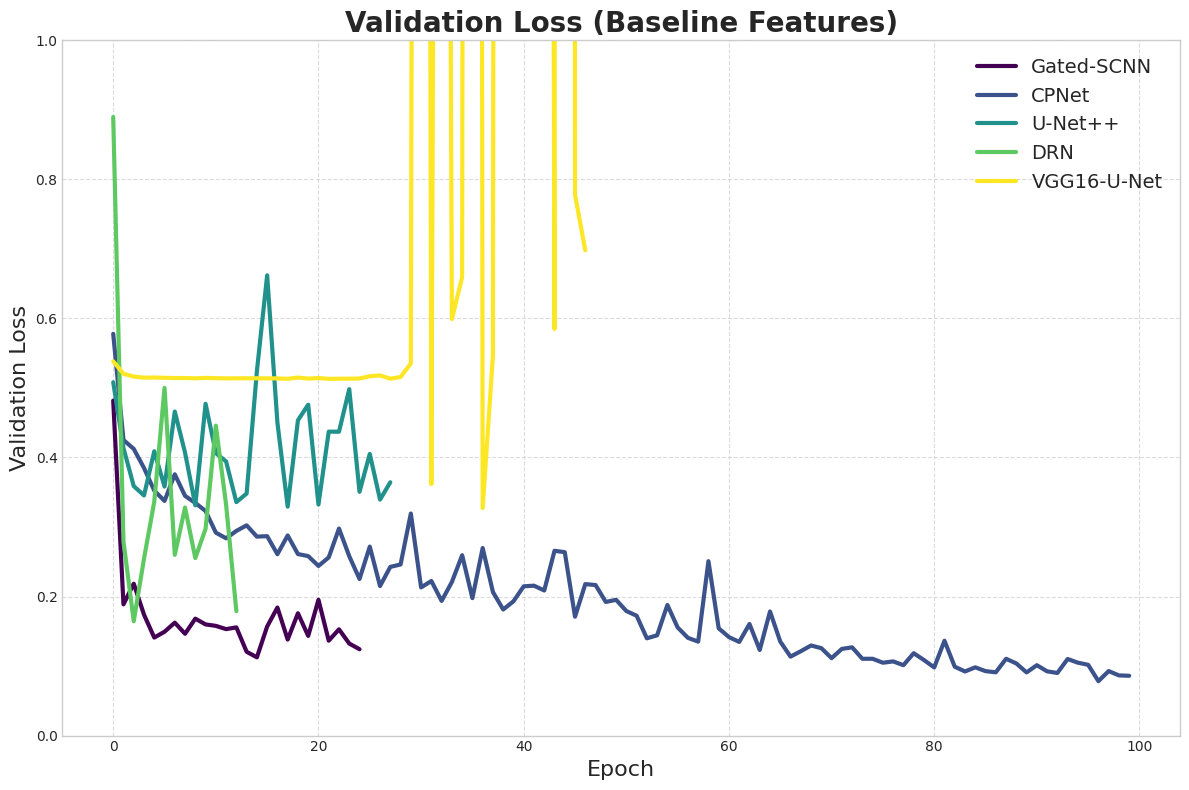

In [116]:
# =====================================================================================#
# Loss Curve
# =====================================================================================#
# Validation Loss
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define colors for each model
colors = plt.cm.viridis(np.linspace(0, 1, len(all_models)))

# Validation loss curves for all models
for i, (model_name, history) in enumerate(dual_pol_histories.items()):
    ax.plot(history['val_loss'], label=f'{model_name}', color=colors[i], linewidth=3)

ax.set_title('Validation Loss (Baseline Features)', fontsize=20, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Validation Loss', fontsize=16)
ax.set_ylim(0, 1.0)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.legend(fontsize=14, loc='upper right')
ax.grid(True, alpha=0.7, linestyle='--')

plt.tight_layout()
plt.show()

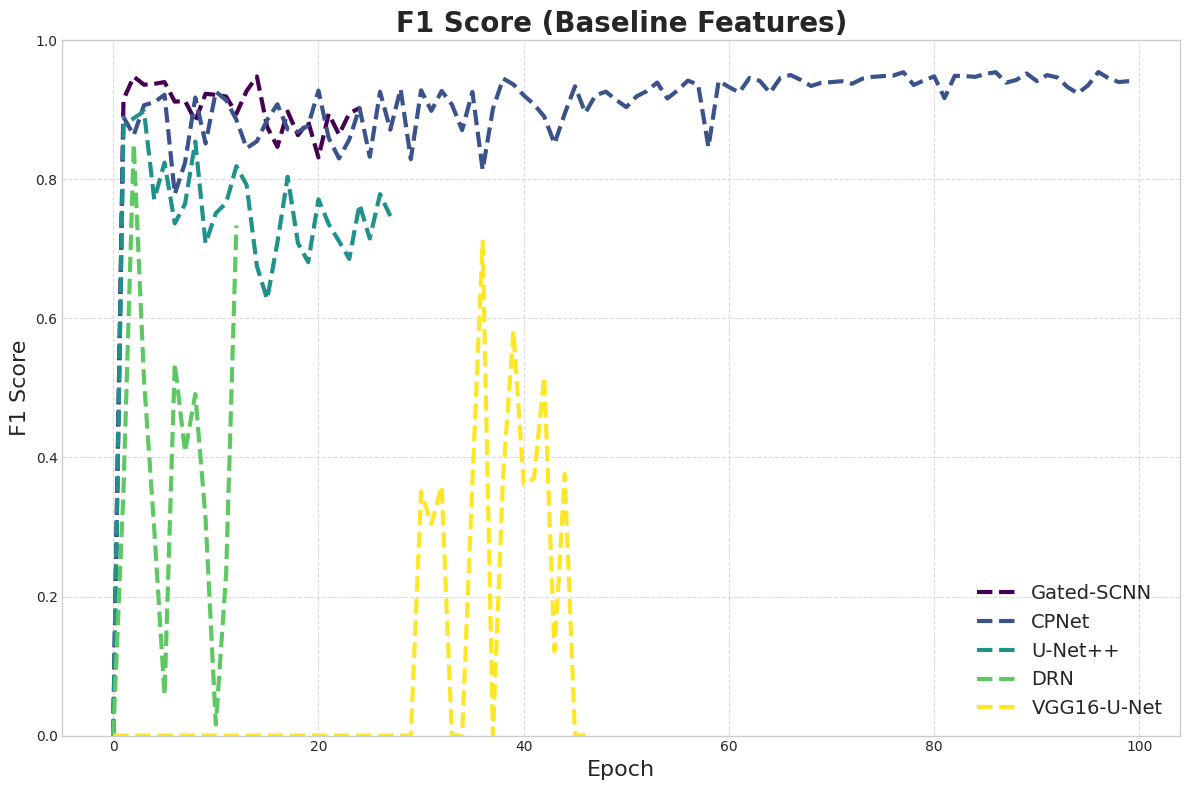

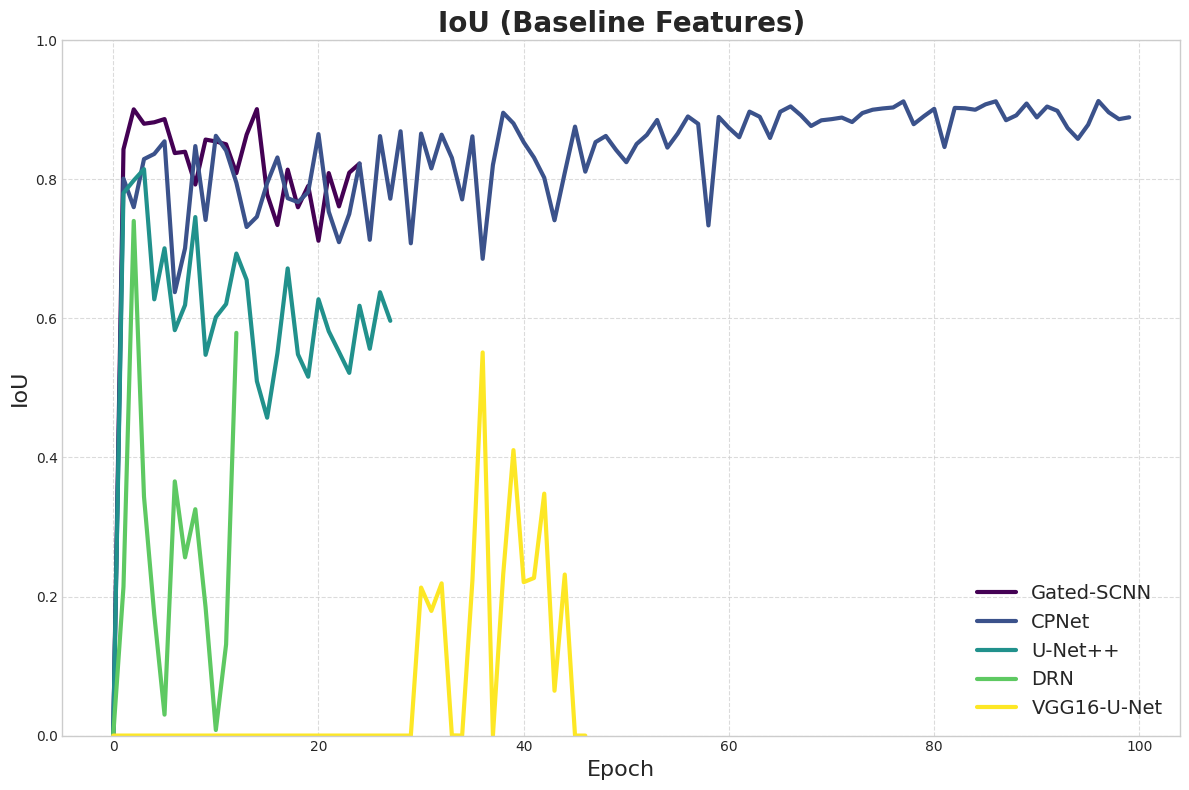

In [117]:
# =====================================================================================#
# F1 Score & IoU Curves - Separate Figures
# =====================================================================================#
plt.style.use('seaborn-v0_8-whitegrid')

# Define colors for each model
colors = plt.cm.viridis(np.linspace(0, 1, len(all_models)))

# F1 Score Figure
plt.figure(figsize=(12, 8))
for i, (model_name, history) in enumerate(dual_pol_histories.items()):
    plt.plot(history['f1_score'], label=f'{model_name}', color=colors[i], linestyle='--', linewidth=3)
plt.title('F1 Score (Baseline Features)', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('F1 Score', fontsize=16)
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# IoU Figure
plt.figure(figsize=(12, 8))
for i, (model_name, history) in enumerate(dual_pol_histories.items()):
    plt.plot(history['iou'], label=f'{model_name}', color=colors[i], linewidth=3)
plt.title('IoU (Baseline Features)', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.ylim(0, 1.0) 
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Flood Prediction Map


============================== 🚀 Running Inference for Gated-SCNN ==============================


Processing Rows: 100%|██████████| 48/48 [00:02<00:00, 18.78it/s]


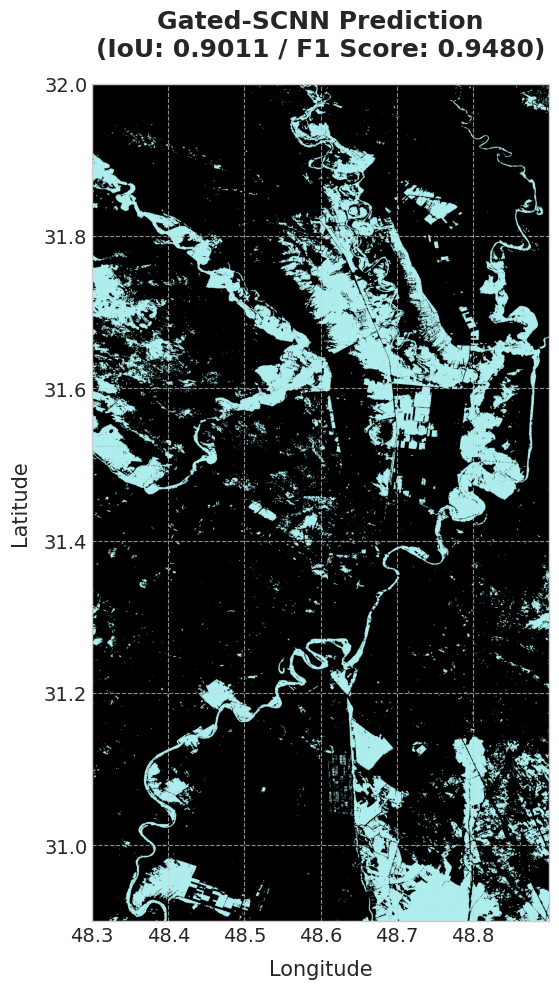


============================== 🚀 Running Inference for CPNet ==============================


Processing Rows: 100%|██████████| 48/48 [00:02<00:00, 18.43it/s]


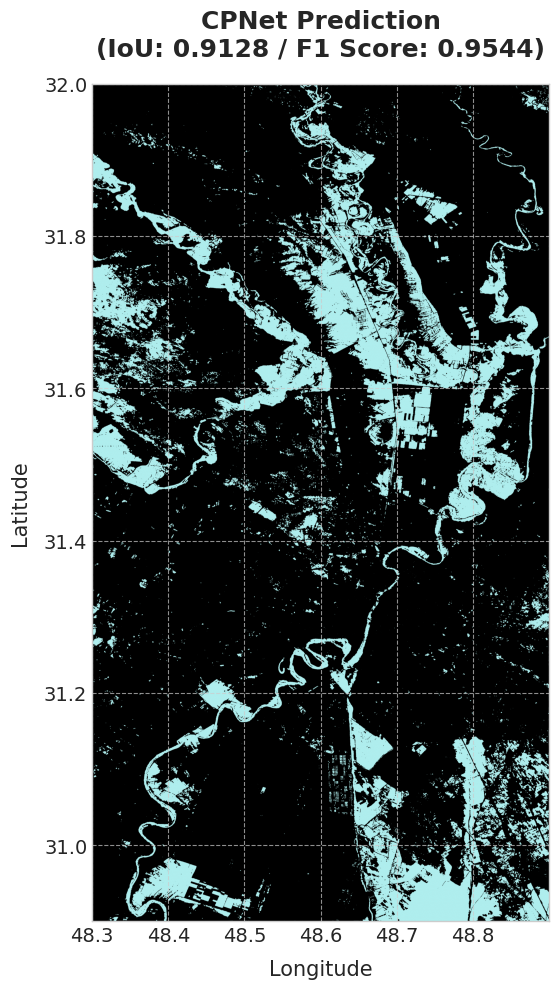


============================== 🚀 Running Inference for U-Net++ ==============================


Processing Rows: 100%|██████████| 48/48 [00:03<00:00, 14.70it/s]


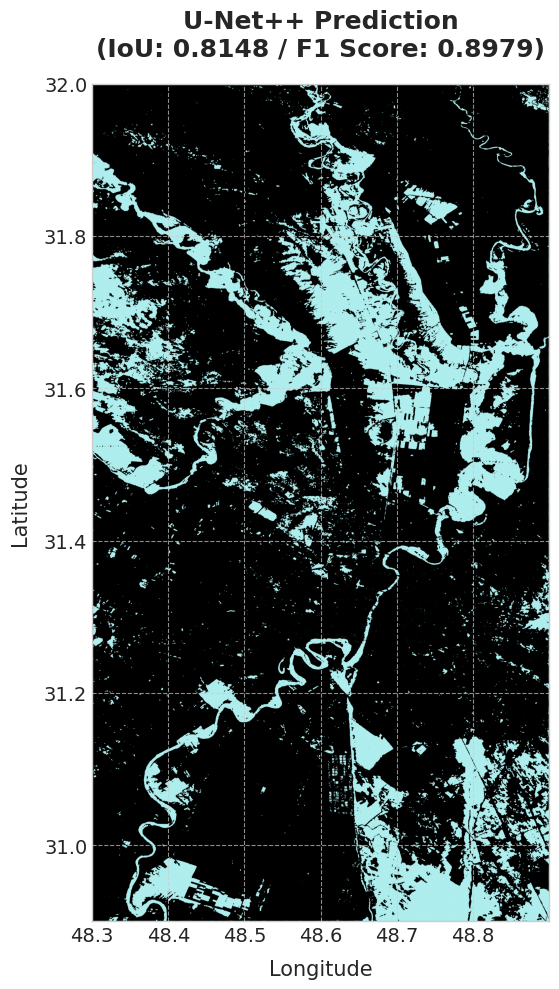


============================== 🚀 Running Inference for DRN ==============================


Processing Rows: 100%|██████████| 48/48 [00:12<00:00,  3.75it/s]


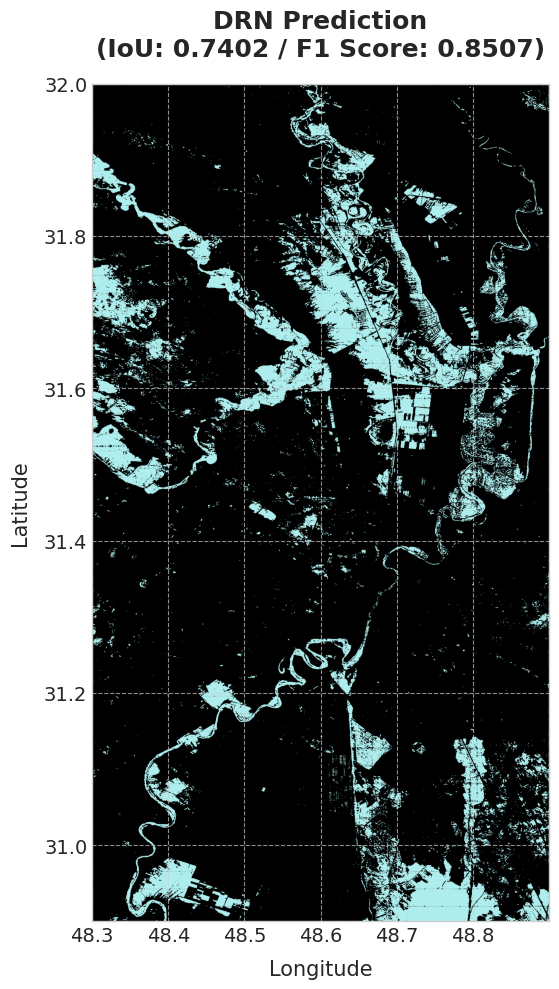


============================== 🚀 Running Inference for VGG16-U-Net ==============================


Processing Rows: 100%|██████████| 48/48 [00:08<00:00,  5.86it/s]


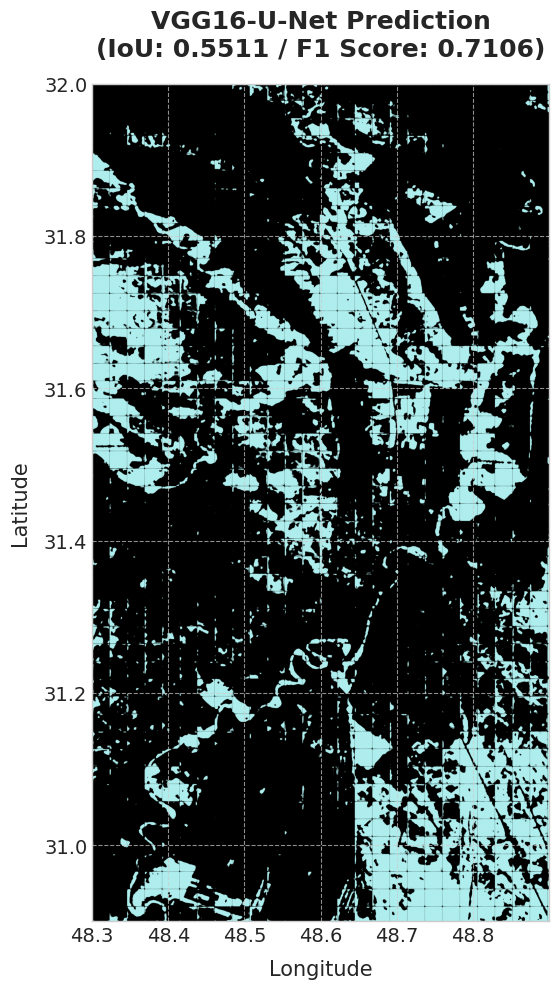

In [112]:
# =====================================================================================#
# Main Inference and Plotting Block
# =====================================================================================#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, model_class in all_models.items():
    print(f"\n{'='*30} 🚀 Running Inference for {model_name} {'='*30}")

    # --- 1. Load Model ---
    model_weights_path = f'./model_results/dual_pol/best_{model_name}_model.pth'
    model = model_class(in_channels=len(DUAL_POL_INDICES), num_classes=2).to(device)
    try:
        model.load_state_dict(torch.load(model_weights_path, weights_only=True))
        model.eval()

    except FileNotFoundError:
        print(f"🚨 WARNING: Weight file not found for {model_name}. Skipping.")
        continue

    # --- 2. Run Inference ---
    data_selected = normalized_sars_data[DUAL_POL_INDICES, :, :]
    prediction_map = inference(model, data_selected, PATCH_SIZE)

    # --- 3. Get Metrics and Plot ---
    best_iou = dual_pol_results_df.loc[model_name, 'iou']
    best_f1_score = dual_pol_results_df.loc[model_name, 'f1_score']

    plot_prediction_map(
        prediction_map=prediction_map,
        meta_data=iran_meta_data,
        model_name=model_name,
        best_iou=best_iou,
        best_f1_score=best_f1_score,
        color_map='paleturquoise'
    )

### 5.2. Dual-Pol & Decomposition & Texture Data

#### Slicing Data

In [28]:
# Use the selected indices of the best algorithm
SELECTED_INDICES = selected_features

# Define number of channels
TOTAL_CHANNELS = len(SELECTED_INDICES)

# Slice the selected channels from the loaded data
input_data = combined_sar_data[SELECTED_INDICES, :, :]
print(f"Shape after feature selection: {input_data.shape}")

Shape after feature selection: (5, 12245, 6679)


#### Create Patches & Data Split

In [29]:
# Create patches
input_patches, _, normalized_sars_data = create_patches(input_data, labeled_data, PATCH_SIZE) # normalized data for inference

# Data split to train and validation
X_train, X_val, y_train, y_val = train_test_split(
    input_patches, label_patches, test_size=0.2, random_state=42
)

Creating Patches: 100%|██████████| 47/47 [00:00<00:00, 945.20it/s]


Patch creation complete. Number of patches: 961


#### Data Loader

In [30]:
# Create Datasets and DataLoaders
train_dataset = FloodDataset(X_train, y_train)
val_dataset = FloodDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print()
print(f"Shape of train dataset: {train_dataset[0][0].shape}")
print(f"Shape of label dataset: {train_dataset[0][1].shape}")
print()
print(f"Shape of validation dataset: {val_dataset[0][0].shape}")
print(f"Shape of label dataset: {val_dataset[0][1].shape}")

Train dataset size: 768
Validation dataset size: 193

Shape of train dataset: torch.Size([5, 256, 256])
Shape of label dataset: torch.Size([256, 256])

Shape of validation dataset: torch.Size([5, 256, 256])
Shape of label dataset: torch.Size([256, 256])


#### Model Training

In [ ]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-5
NUM_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10
save_path = './model_results/hybrid_pol'

# --- Run Training for All Models ---
final_results = {}
all_histories = {}

try:
    for model_name, model_class in all_models.items():
        best_iou, best_f1, history = train_model(
            model_name=model_name,
            model_class=model_class,
            train_loader=train_loader,
            val_loader=val_loader,
            total_channels=TOTAL_CHANNELS,
            num_epochs=NUM_EPOCHS,
            lr=LEARNING_RATE,
            patience=EARLY_STOPPING_PATIENCE,
            save_path=save_path
        )

        final_results[model_name] = {"iou": best_iou, "f1_score": best_f1}
        all_histories[model_name] = history

    # --- Save and Print Final Summary ---
    results_df = pd.DataFrame.from_dict(final_results, orient='index')
    results_df = results_df.reset_index().rename(columns={'index': 'model_name'})
    results_df.to_csv(os.path.join(save_path, 'all_models_summary.csv'))
    print("\n\n" + "="*30 + " 📊 Final Summary " + "="*30)
    print(results_df)

    notipy.send_success()

except Exception as e:
    notipy.send_error(e)
    print(e)

============================== 🖥️ Training Gated-SCNN model ==============================
Epoch 1: 🎉 New best IoU: 0.7685
Epoch 2: 🎉 New best IoU: 0.7877
Epoch 3: 🎉 New best IoU: 0.7970
Epoch 4: 🎉 New best IoU: 0.7982
Epoch 6: 🎉 New best IoU: 0.8057
Epoch 11: 🎉 New best IoU: 0.8077
Epoch 13: 🎉 New best IoU: 0.8157
Epoch 15: 🎉 New best IoU: 0.8201
Epoch 17: 🎉 New best IoU: 0.8228
Epoch 23: 🎉 New best IoU: 0.8252
Epoch 25: 🎉 New best IoU: 0.8282
Epoch 26: 🎉 New best IoU: 0.8284
Epoch 30: 🎉 New best IoU: 0.8308
Epoch 31: 🎉 New best IoU: 0.8321
Epoch 37: 🎉 New best IoU: 0.8324
Epoch 43: 🎉 New best IoU: 0.8338
Epoch 51: 🎉 New best IoU: 0.8348
Epoch 56: 🎉 New best IoU: 0.8362
Epoch 62: 🎉 New best IoU: 0.8382
Epoch 73: 🎉 New best IoU: 0.8390
Epoch 80: 🎉 New best IoU: 0.8391

🛑 Early stopping triggered at epoch 90

--- Finished training for Gated-SCNN ---
============================== 🖥️ Training CPNet model ==============================
Epoch 1: 🎉 New best IoU: 0.6760
Epoch 2: 🎉 New best I

#### Loss Curve & Evaluation Metrics

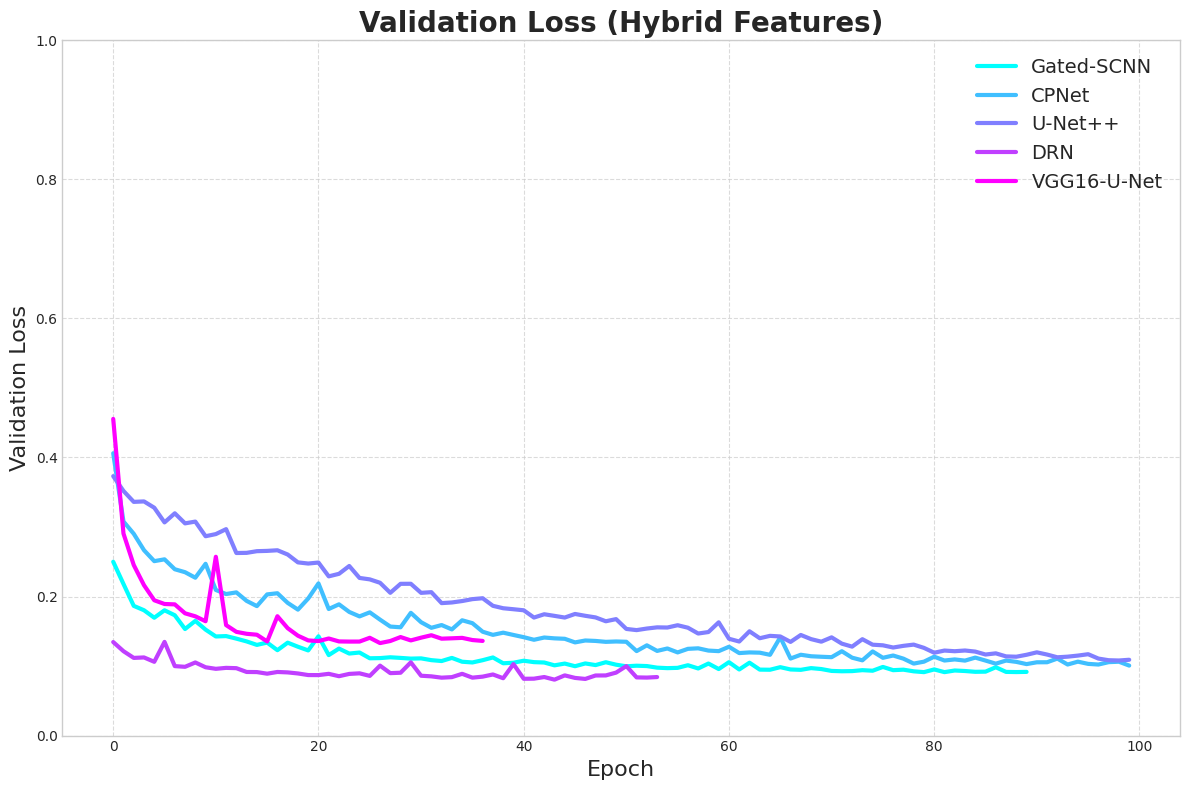

In [118]:
# =====================================================================================#
# Loss Curve
# =====================================================================================#
# Validation Loss
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define colors for each model using a pastel colormap
# 'Pastel1' is a great choice for a soft, aesthetic look.
colors = plt.cm.cool(np.linspace(0, 1, len(all_models)))

# Validation loss curves for all models
for i, (model_name, history) in enumerate(all_histories.items()):
    ax.plot(history['val_loss'], label=f'{model_name}', color=colors[i], linewidth=3) # Made lines a bit thicker for visibility

ax.set_title('Validation Loss (Hybrid Features)', fontsize=20, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Validation Loss', fontsize=16)
ax.set_ylim(0, 1.0)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.legend(fontsize=14, loc='upper right')
ax.grid(True, alpha=0.7, linestyle='--')

plt.tight_layout()
plt.show()

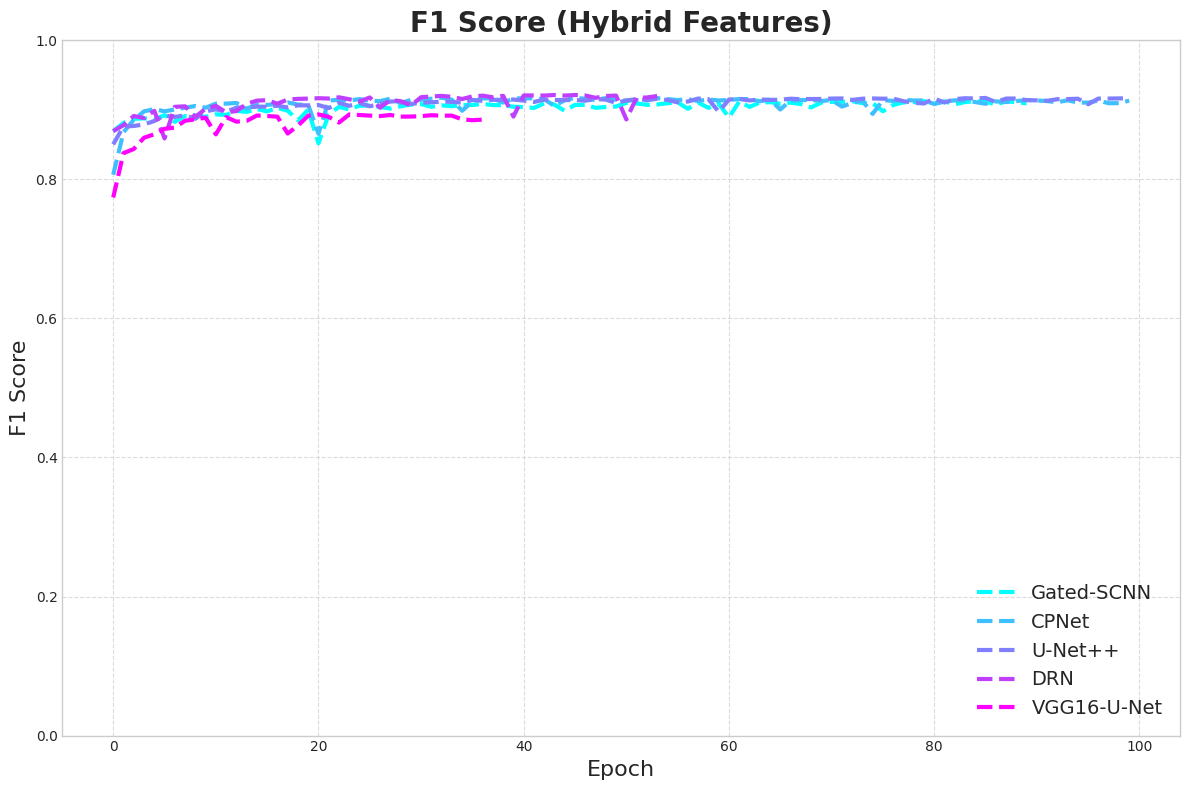

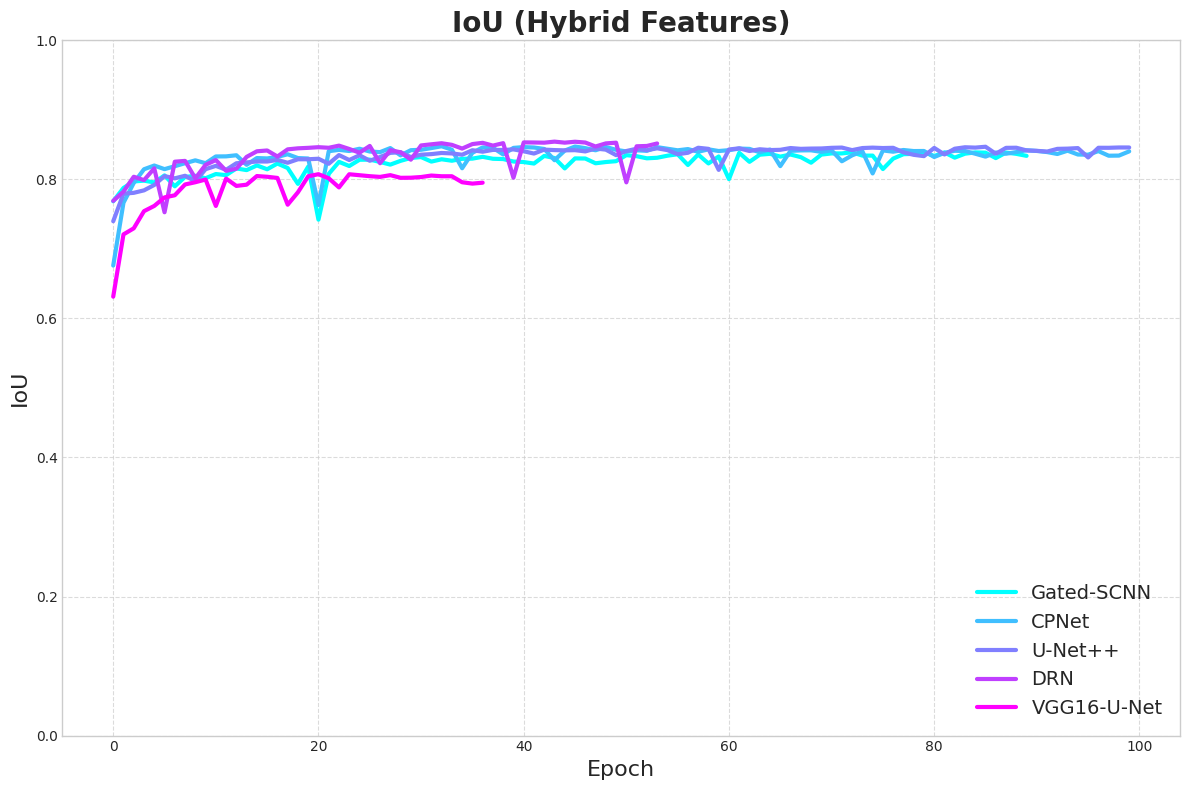

In [119]:
# =====================================================================================#
# F1 Score & IoU Curves - Separate Figures
# =====================================================================================#
plt.style.use('seaborn-v0_8-whitegrid')

# Define colors for each model
colors = plt.cm.cool(np.linspace(0, 1, len(all_models)))

# F1 Score Figure
plt.figure(figsize=(12, 8))
for i, (model_name, history) in enumerate(all_histories.items()):
    plt.plot(history['f1_score'], label=f'{model_name}', color=colors[i], linestyle='--', linewidth=3)
plt.title('F1 Score (Hybrid Features)', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('F1 Score', fontsize=16)
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# IoU Figure
plt.figure(figsize=(12, 8))
for i, (model_name, history) in enumerate(all_histories.items()):
    plt.plot(history['iou'], label=f'{model_name}', color=colors[i], linewidth=3)
plt.title('IoU (Hybrid Features)', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.legend(fontsize=14, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Plot Flood Prediction Map

In [87]:
# =====================================================================================#
# Main Inference and Plotting Block
# =====================================================================================#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name, model_class in all_models.items():
    print(f"\n{'='*30} 🚀 Running Inference for {model_name} {'='*30}")

    # --- 1. Load Model ---
    model_weights_path = f'./model_results/dual_pol/best_{model_name}_model.pth'
    model = model_class(in_channels=TOTAL_CHANNELS, num_classes=2).to(device)
    try:
        model.load_state_dict(torch.load(model_weights_path, weights_only=True))
        model.eval()

    except FileNotFoundError:
        print(f"🚨 WARNING: Weight file not found for {model_name}. Skipping.")
        continue

    # --- 2. Run Inference ---
    prediction_map = inference(model, normalized_sars_data, PATCH_SIZE)

    # --- 3. Get Metrics and Plot ---
    best_iou = results_df.loc[model_name, 'iou']
    best_f1_score = results_df.loc[model_name, 'f1_score']

    plot_prediction_map(
        prediction_map=prediction_map,
        meta_data=iran_meta_data,
        model_name=model_name,
        best_iou=best_iou,
        best_f1_score=best_f1_score
    )


============================== 🚀 Running Inference for Gated-SCNN ==============================


Processing Rows:   0%|          | 0/48 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 2, 3, 3], expected input[1, 27, 256, 256] to have 2 channels, but got 27 channels instead

#### Labeled Map

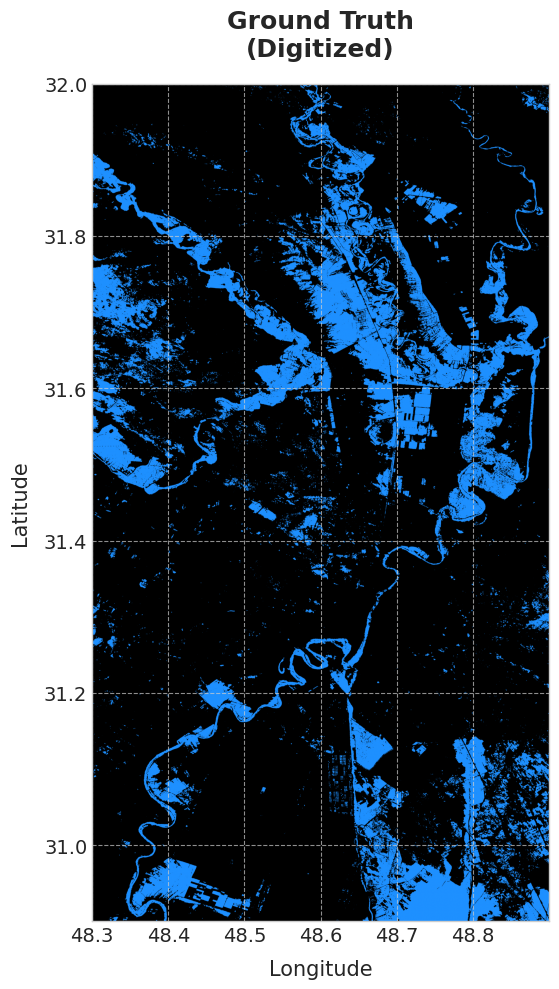

In [65]:
# Plot Ground Truth
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Custom color map (0: black, 1: lightskyblue)
colors = ['black', 'dodgerblue']
cmap = mcolors.ListedColormap(colors)
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

with rasterio.open(IRAN_LABEL_PATH) as lbl_src:
    ground_truth_map = lbl_src.read(1)
    nodata_value = lbl_src.nodata
    if nodata_value is not None:
        ground_truth_map[ground_truth_map == nodata_value] = 0

# Plot Ground Truth
show(ground_truth_map,
    ax=ax,
    transform=iran_meta_data['transform'],
    cmap=cmap,
    norm=norm)
ax.set_title('Ground Truth\n(Digitized)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=15, labelpad=10)
ax.set_ylabel('Latitude', fontsize=15, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# North Korea

In [69]:
# Load Data
NK_sar_data, NK_labeled_data, NK_meta_data= load_data(NK_SAR_PATHS, NK_LABEL_PATH)
NK_labeled_origin_data = NK_labeled_data.copy()

SAR data shape: (27, 11689, 15919)
Labeled data shape: (11689, 15919)


In [44]:
# Select channels
NK_input_data = NK_sar_data[SELECTED_INDICES, :, :]

# Create patches
NK_input_patches, NK_label_patches, NK_normalized_sars_data = create_patches(NK_input_data, NK_labeled_data, PATCH_SIZE) # normalized data for inference

Creating Patches: 100%|██████████| 45/45 [00:00<00:00, 380.55it/s]


Patch creation complete. Number of patches: 936


Processing Rows: 100%|██████████| 46/46 [00:06<00:00,  7.55it/s]


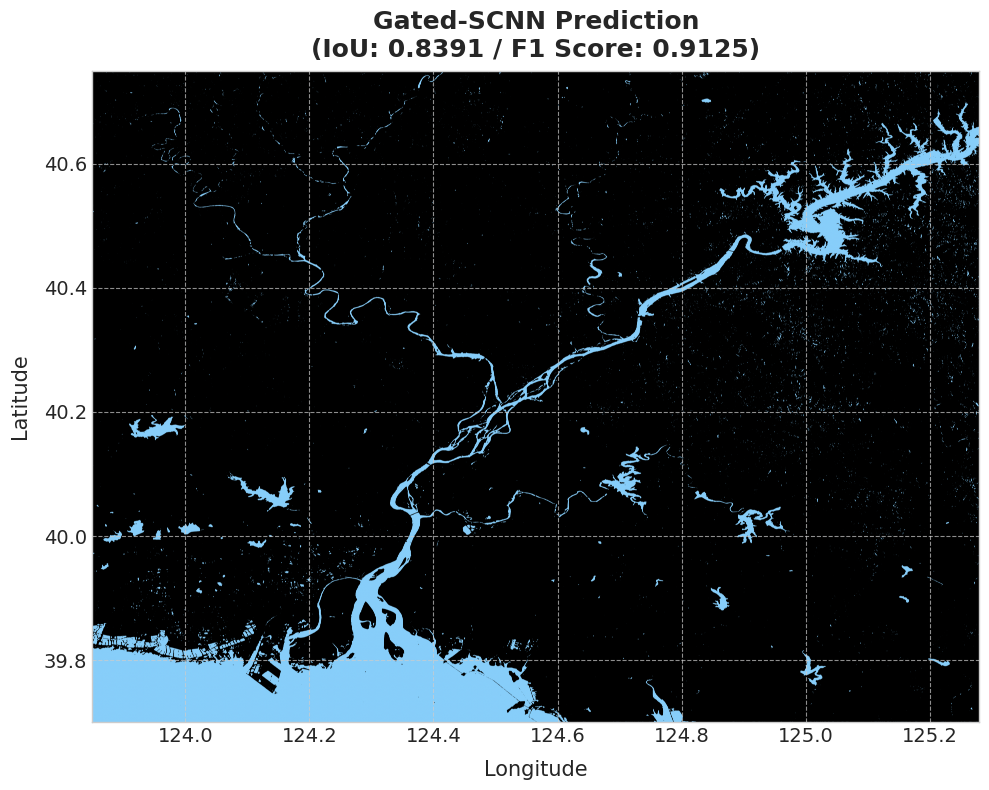

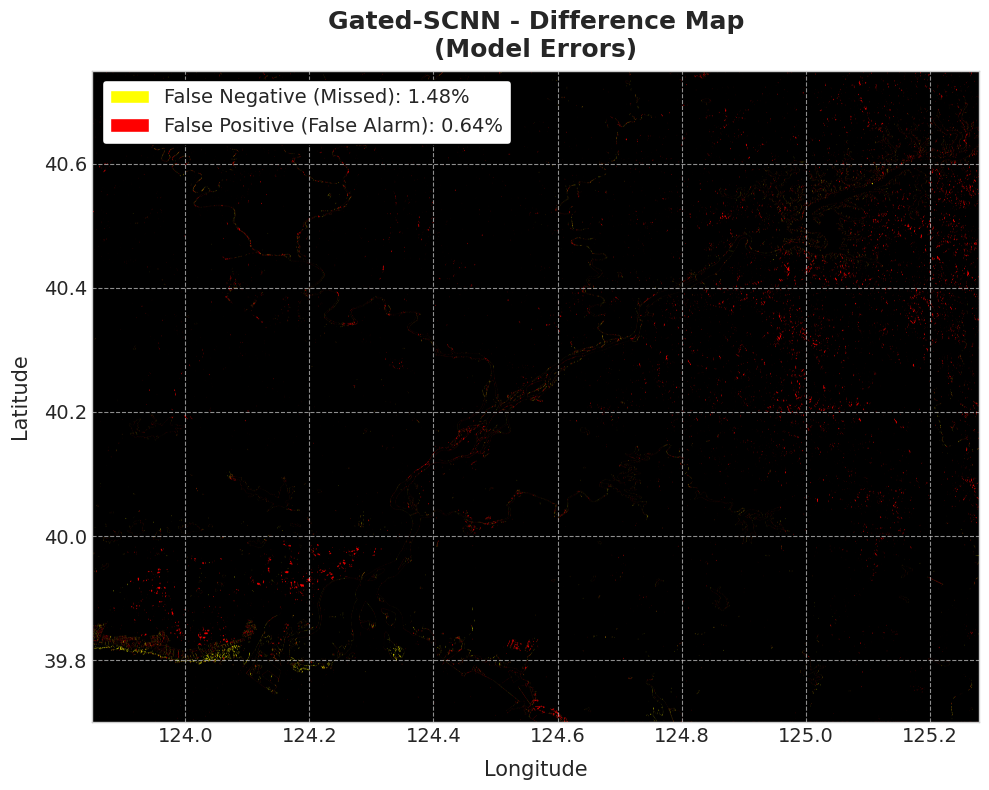

Processing Rows: 100%|██████████| 46/46 [00:06<00:00,  7.34it/s]


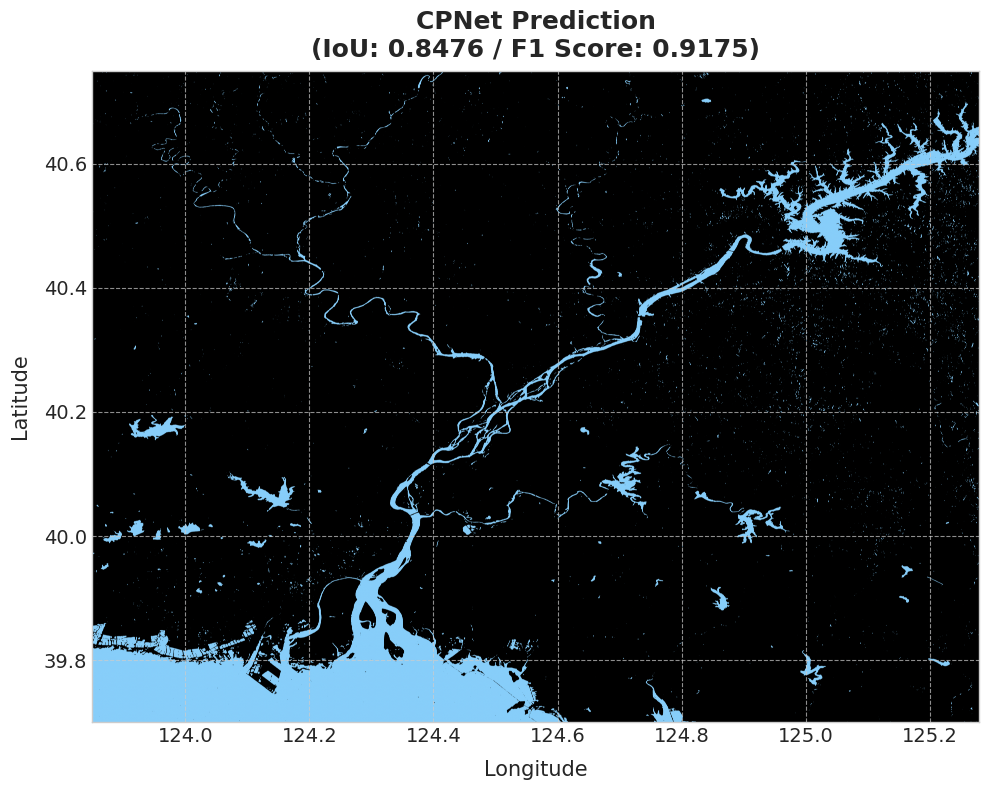

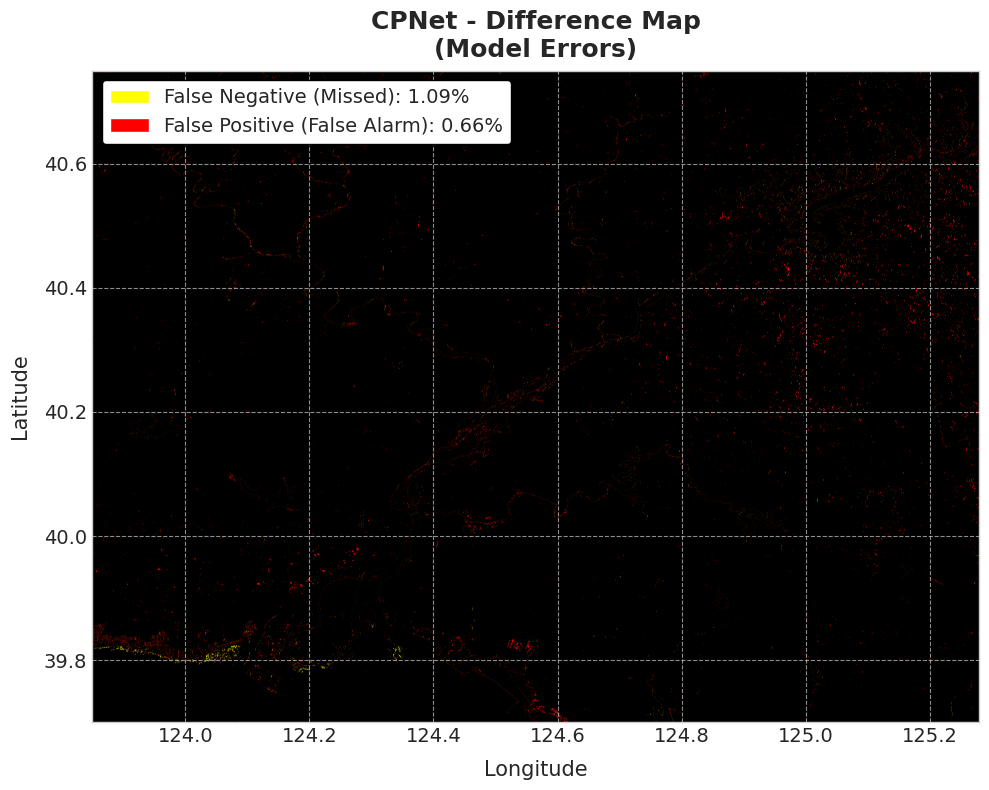

Processing Rows: 100%|██████████| 46/46 [00:07<00:00,  6.01it/s]


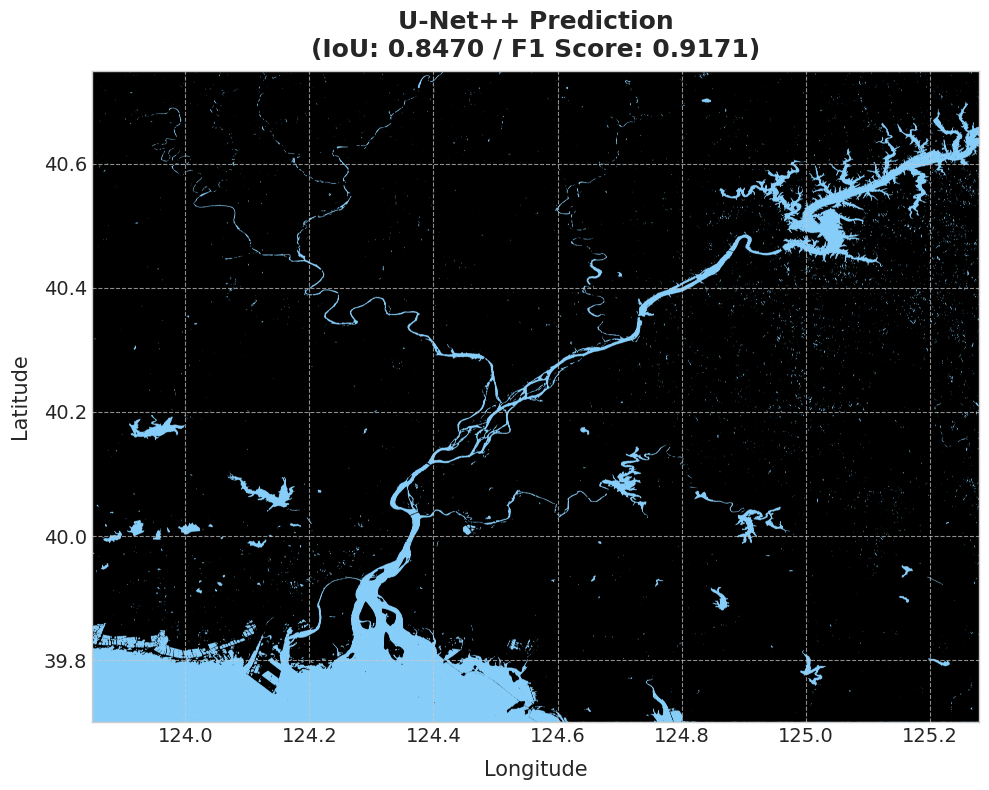

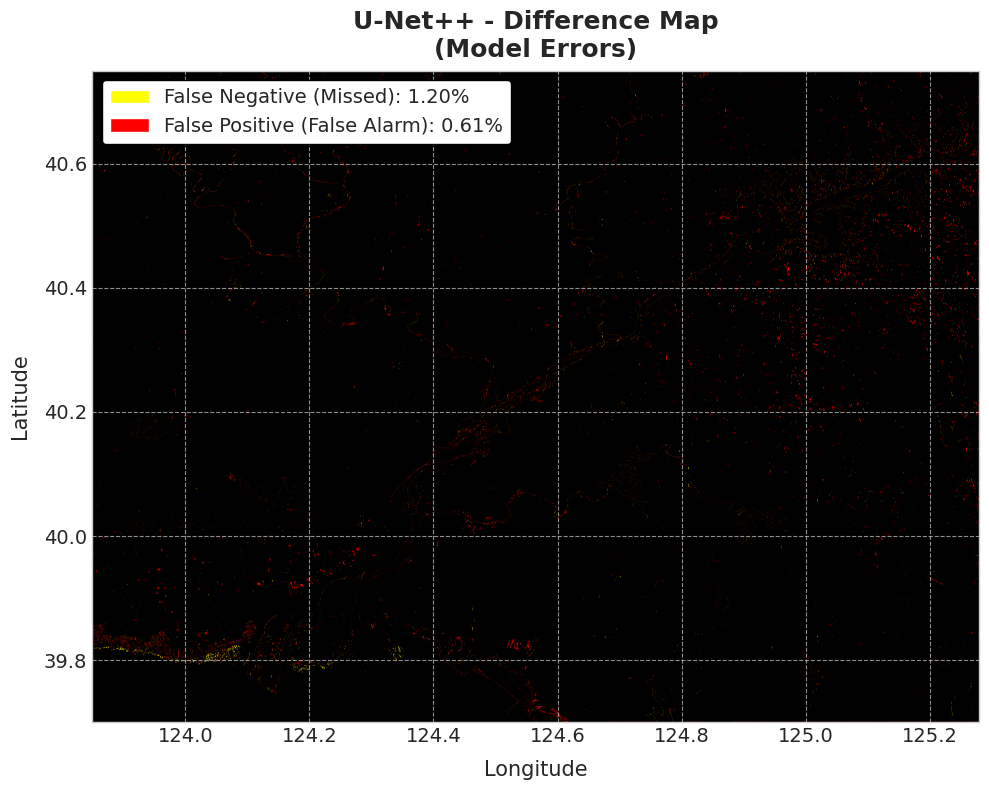

Processing Rows: 100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


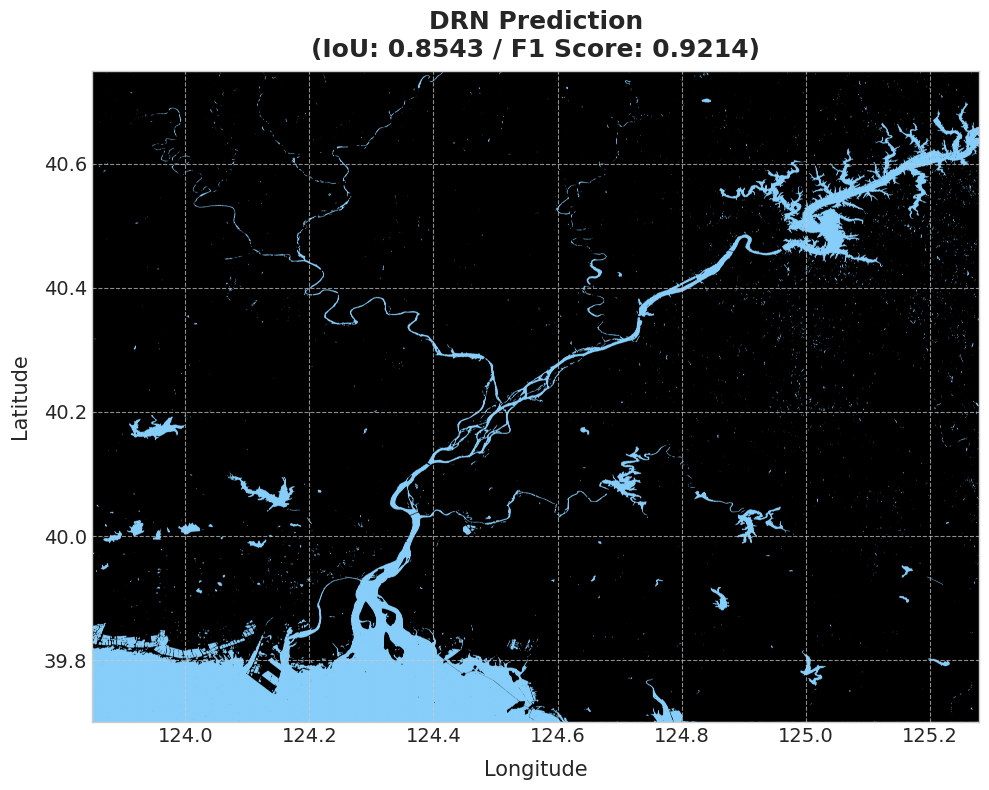

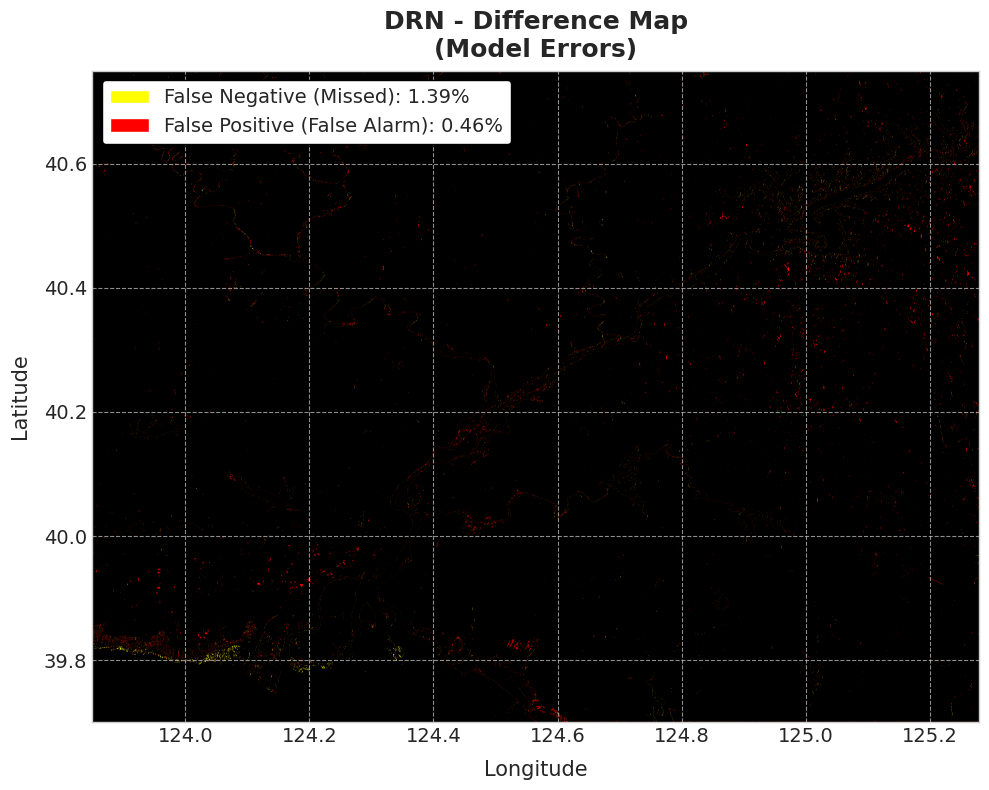

Processing Rows: 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


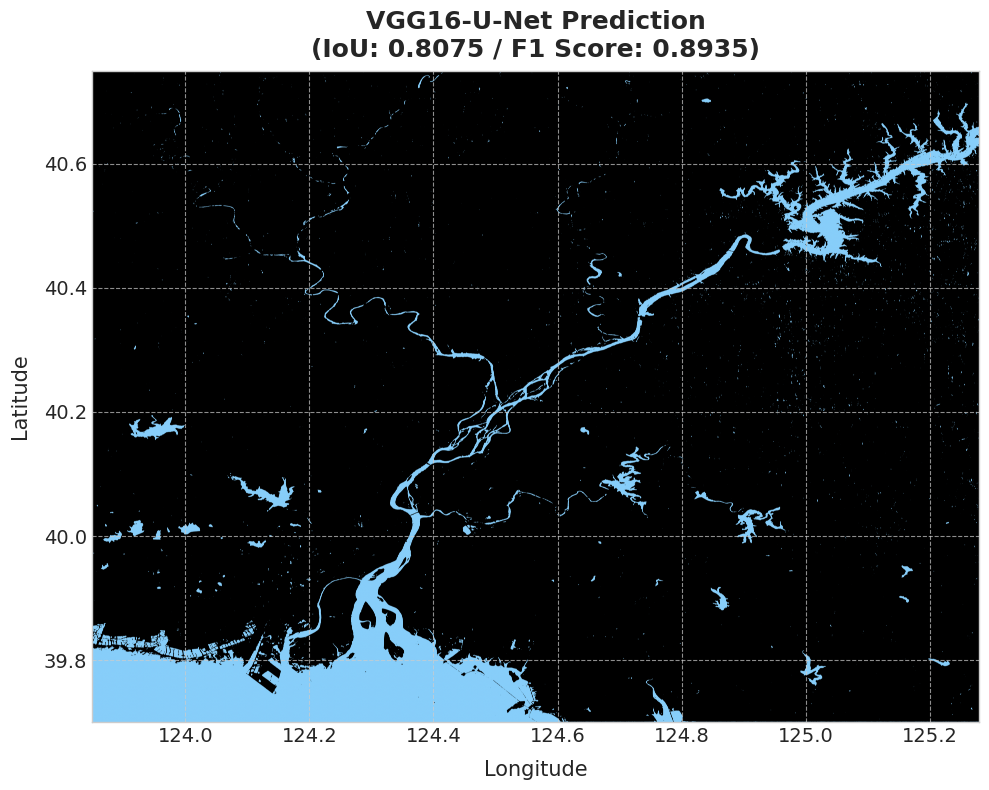

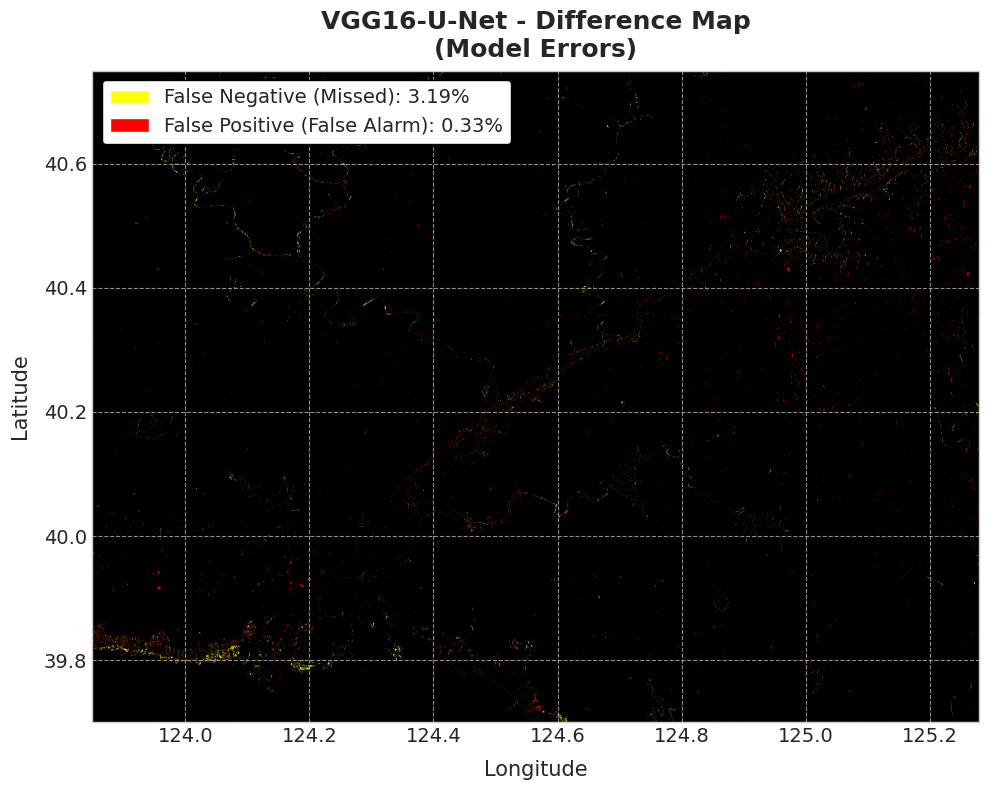

In [67]:
# =====================================================================================#
# Inference
# =====================================================================================#
for model_name, model_class in all_models.items():
    model_weights_path = f'./model_results/best_{model_name}_model.pth'
    SelectedModelClass = model_class

    # Define the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate the selected model
    model = SelectedModelClass(in_channels=TOTAL_CHANNELS, num_classes=2).to(device)

    try:
        model.load_state_dict(torch.load(model_weights_path, weights_only=True))
        model.eval()
    except FileNotFoundError:
        print(f"🚨 WARNING: Weight file not found at {model_weights_path}. Using an untrained model.")

    # Get height and width from the pre-loaded data
    h, w = NK_normalized_sars_data.shape[1:]

    # Create an empty canvas to store the prediction results
    prediction_map = np.zeros((h, w), dtype=np.uint8)

    with torch.no_grad():
        for y in tqdm(range(0, h, PATCH_SIZE), desc="Processing Rows"):
            for x in range(0, w, PATCH_SIZE):
                y_end = min(y + PATCH_SIZE, h)
                x_end = min(x + PATCH_SIZE, w)

                # Use the pre-processed numpy array
                patch = NK_normalized_sars_data[:, y:y_end, x:x_end]

                # Check if padding is needed
                patch_h, patch_w = patch.shape[1], patch.shape[2]

                if patch_h != PATCH_SIZE or patch_w != PATCH_SIZE:
                    # Calculate the necessary padding size
                    pad_h = PATCH_SIZE - patch_h
                    pad_w = PATCH_SIZE - patch_w

                    # Add padding in the order of (right, left, top, bottom)
                    # Only add padding to the right and bottom
                    padding = (0, pad_w, 0, pad_h)
                    patch = np.pad(patch, ((0, 0), (0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

                patch_tensor = torch.from_numpy(patch).unsqueeze(0).float().to(device)

                output = model(patch_tensor)
                pred_patch_full = torch.argmax(output, dim=1).squeeze().cpu().numpy()

                # Extract the predicted patch from the full patch
                pred_patch = pred_patch_full[:patch_h, :patch_w]

                prediction_map[y:y_end, x:x_end] = pred_patch

    # =====================================================================================#
    # Plot Prediction
    # =====================================================================================#
    best_iou = results_df[results_df['model_name'] == model_name]['iou'].values[0].round(4)
    best_f1_score = results_df[results_df['model_name'] == model_name]['f1_score'].values[0].round(4)

    # Plot Prediction vs. Ground Truth
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Custom color map (0: black, 1: lightskyblue)
    colors = ['black', 'lightskyblue']
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # 1. Model prediction map
    show(prediction_map,
        ax=ax,
        transform=meta_data['transform'],
        cmap=cmap,
        norm=norm)
    ax.set_title(f'{model_name} Prediction\n(IoU: {best_iou:.4f} / F1 Score: {best_f1_score:.4f})', fontsize=18, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=15, labelpad=10)
    ax.set_ylabel('Latitude', fontsize=15, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # =====================================================================================#
    # Plot Difference Map
    # =====================================================================================#
    # --- 1. Create the Difference Map ---
    difference_map = np.zeros_like(prediction_map, dtype=np.uint8)

    # Calculate False Negative (FN) mask: where ground truth is 1 but prediction is 0
    fn_mask = (ground_truth_map == 1) & (prediction_map == 0)
    difference_map[fn_mask] = 1  # Assign value 1 to FN areas

    # Calculate False Positive (FP) mask: where ground truth is 0 but prediction is 1
    fp_mask = (ground_truth_map == 0) & (prediction_map == 1)
    difference_map[fp_mask] = 2  # Assign value 2 to FP areas

    # Calculate the percentage of FN and FP
    total_positive_pixels = np.sum(ground_truth_map == 1)
    total_negative_pixels = np.sum(ground_truth_map == 0)
    
    fn_percentage = (np.sum(fn_mask) / (total_positive_pixels + 1e-6)) * 100
    fp_percentage = (np.sum(fp_mask) / (total_negative_pixels + 1e-6)) * 100

    # --- 2. Setup Plot and Colormap ---
    # Create a single figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), facecolor='white')

    # Create a custom colormap for the difference map
    # 0: Black (Match/Background), 1: Yellow (FN), 2: Red (FP)
    diff_colors = ['black', 'yellow', 'red']
    diff_cmap = mcolors.ListedColormap(diff_colors)
    diff_bounds = [-0.5, 0.5, 1.5, 2.5]
    diff_norm = mcolors.BoundaryNorm(diff_bounds, diff_cmap.N)

    # --- 3. Plot the Map ---
    # Plot the difference map using geographic coordinates from the metadata
    show(difference_map,
        ax=ax,
        transform=meta_data['transform'],
        cmap=diff_cmap,
        norm=diff_norm)

    # --- 4. Customize the Plot ---
    # Set titles and labels
    ax.set_title(f'{model_name} - Difference Map\n(Model Errors)', fontsize=18, fontweight='bold', pad=10)
    ax.set_xlabel('Longitude', fontsize=15, labelpad=10)
    ax.set_ylabel('Latitude', fontsize=15, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Create a custom legend to explain the colors
    legend_elements = [
        Patch(facecolor='yellow', edgecolor='w', label=f'False Negative (Missed): {fn_percentage:.2f}%'),
        Patch(facecolor='red', edgecolor='w', label=f'False Positive (False Alarm): {fp_percentage:.2f}%')
    ]
    ax.legend(handles=legend_elements,
            loc='upper left',
            facecolor='white',
            edgecolor='black',
            frameon=True,
            framealpha=1,
            fontsize=14)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

#### Labeled Map

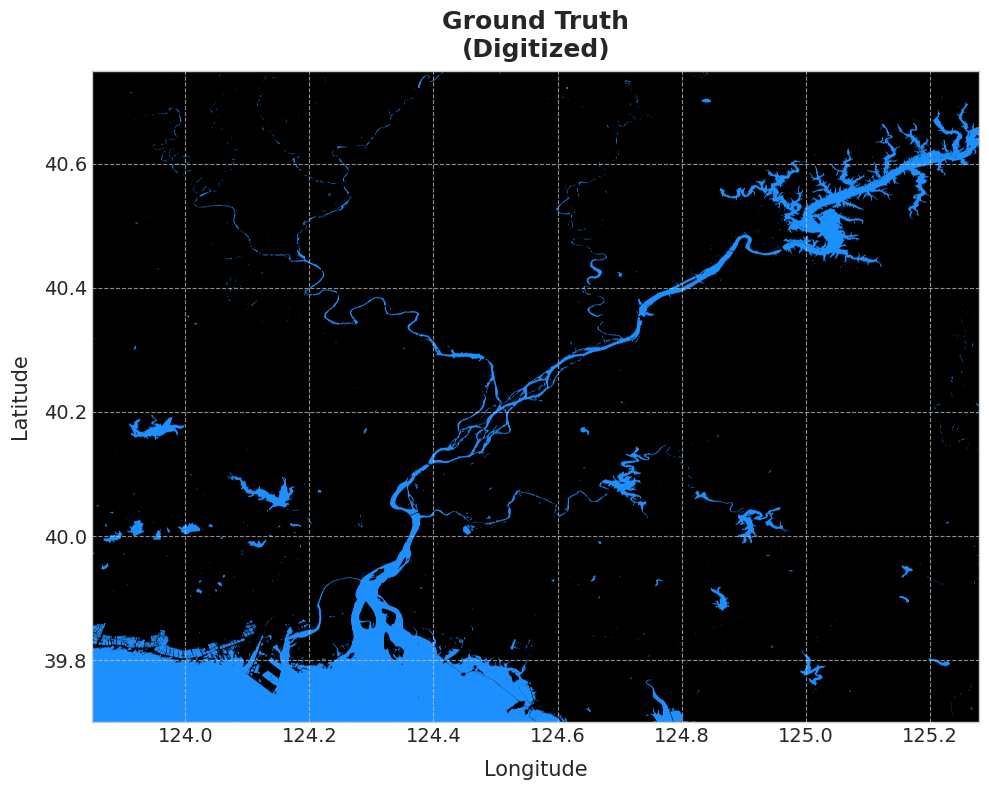

In [70]:
# Plot Ground Truth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Custom color map (0: black, 1: lightskyblue)
colors = ['black', 'dodgerblue']
cmap = mcolors.ListedColormap(colors)
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

with rasterio.open(NK_LABEL_PATH) as lbl_src:
    ground_truth_map = lbl_src.read(1)
    nodata_value = lbl_src.nodata
    if nodata_value is not None:
        ground_truth_map[ground_truth_map == nodata_value] = 0

# Plot Ground Truth
show(ground_truth_map,
    ax=ax,
    transform=NK_meta_data['transform'],
    cmap=cmap,
    norm=norm)
ax.set_title('Ground Truth\n(Digitized)', fontsize=18, fontweight='bold', pad=10)
ax.set_xlabel('Longitude', fontsize=15, labelpad=10)
ax.set_ylabel('Latitude', fontsize=15, labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()